# Customer Segmentation with K Means and Classification

The purpose of this project is to create a model that predicts the cluster that a customer should belong to. This sort of activity would enable a company to cater and respond to the needs of their customers more efficiently, as well as provide targeted marketing, offers and services to them.

**Data:**

The data used for this is the Online Retail dataset found on the UCI Machine Learning Repository website through the following link: https://archive.ics.uci.edu/ml/datasets/online+retail

Firstly, utilising NLP techniques, product descriptions will be used to create product categories. Customer purchase history will be aggregated to create a single entry per customer. This information will be used to create customer clusters.

These clusters will then be used as labels to build a classifier that predicts the cluster that a new customer belongs to.

By converting an unsupervised into a supervised task, it is possible to evaluate the performance of the model, and, with the generation of further data, feed back into the model to improve performance.

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

## Load and explore the data

In [2]:
data = pd.read_excel('data/Online_Retail.xlsx', dtype={'CustomerID': str,'InvoiceNo': str})
print('Dataframe dimensions:', data.shape)
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

Dataframe dimensions: (541909, 8)


In [3]:
data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom

In [4]:
tab_info = pd.DataFrame(data.dtypes).T.rename(index={0:'column type'})
tab_info = tab_info.append(pd.DataFrame(data.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info = tab_info.append(pd.DataFrame(data.isnull().sum()/data.shape[0]*100).T.
                         rename(index = {0:'null values (%)'}))
print ("Display information about column types and number of null values")
print 
display(tab_info)

Display information about column types and number of null values


InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type         object    object      object    int64  datetime64[ns]   
null values (nb)         0         0        1454        0               0   
null values (%)          0         0    0.268311        0               0   

                 UnitPrice CustomerID Country  
column type        float64     object  object  
null values (nb)         0     135080       0  
null values (%)          0    24.9267       0

From the above, nearly 25% of CustomerID rows are null, thus nearly 25% of data entries are not assigned to any customer. It would not be possible to utilise these entries in clustering customers. Therefore, these entries must be removed.

### Drop Null Rows

In [5]:
data.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', data.shape)

tab_info = pd.DataFrame(data.dtypes).T.rename(index = {0:'column type'})
tab_info = tab_info.append(pd.DataFrame(data.isnull().sum()).T.rename(index = {0:'null values (nb)'}))
tab_info = tab_info.append(pd.DataFrame(data.isnull().sum()/data.shape[0]*100).T.
                         rename(index = {0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (406829, 8)


InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type         object    object      object    int64  datetime64[ns]   
null values (nb)         0         0           0        0               0   
null values (%)          0         0           0        0               0   

                 UnitPrice CustomerID Country  
column type        float64     object  object  
null values (nb)         0          0       0  
null values (%)          0          0       0

### Exploring Country 

In [6]:
temp = data[['CustomerID', 'InvoiceNo', 'Country']].groupby(
    ['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('No. of cuntries in dataframe: {}'.format(len(countries)))

No. of cuntries in dataframe: 37


In [7]:
temp_no_of_order_per_count = data[['CustomerID','Country']].groupby(['Country']).count()
temp_no_of_order_per_count = temp_no_of_order_per_count.reset_index(drop = False)

print("Country-wise order calculation")
print
print (temp_no_of_order_per_count.sort_values(
    by = 'CustomerID', ascending = False).rename(index = str,
                                        columns = {"CustomerID": "Country wise number of order"}))

Country-wise order calculation
                 Country  Country wise number of order
35        United Kingdom                        361878
14               Germany                          9495
13                France                          8491
10                  EIRE                          7485
30                 Spain                          2533
23           Netherlands                          2371
3                Belgium                          2069
32           Switzerland                          1877
26              Portugal                          1480
0              Australia                          1259
24                Norway                          1086
18                 Italy                           803
6        Channel Islands                           758
12               Finland                           695
7                 Cyprus                           622
31                Sweden                           462
1                Austria          

### Exploring Customers and Products

In [8]:
pd.DataFrame([{'products': len(data['StockCode'].value_counts()),    
               'transactions': len(data['InvoiceNo'].value_counts()),
               'customers': len(data['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], 
              index = ['quantity'])

products  transactions  customers
quantity      3684         22190       4372

There are a total of 4,372 customers who bought 3,684 different products, with a total of 22,190 transactions. 

In [9]:
#number of products purchased per transaction
temp = data.groupby(by = ['CustomerID', 'InvoiceNo'], as_index = False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

CustomerID InvoiceNo  Number of products
0      12346    541431                   1
1      12346   C541433                   1
2      12347    537626                  31
3      12347    542237                  29
4      12347    549222                  24
5      12347    556201                  18
6      12347    562032                  22
7      12347    573511                  47
8      12347    581180                  11
9      12348    539318                  17

The above shows that customers conduct multiple transactions. It also shows that the number of products purchased per customer per transaction varies a great deal - some customers appear to only buy one product per transaction (e.g. CustomerID = 12346), whereas other buy a large number of items per transaction (e.g. CustomerID = 12347). It also suggests that some customers conduct more separate transactions than others. 

The C-prefixed InvoiceNo indicates that order was cancelled; these can be analysed.

### Exploring Cancelled Orders

In [10]:
nb_products_per_basket['order_cancelled'] = nb_products_per_basket['InvoiceNo'].apply(
    lambda x:int('C' in x))
display(nb_products_per_basket[:5])

n1 = nb_products_per_basket['order_cancelled'].sum()
n2 = nb_products_per_basket.shape[0]
percentage = (n1/n2)*100
print('Number of orders cancelled: {}/{} ({:.2f}%) '.format(n1, n2, percentage))

CustomerID InvoiceNo  Number of products  order_cancelled
0      12346    541431                   1                0
1      12346   C541433                   1                1
2      12347    537626                  31                0
3      12347    542237                  29                0
4      12347    549222                  24                0

Number of orders cancelled: 3654/22190 (16.47%) 


In [11]:
display(data.sort_values('CustomerID')[:5])

InvoiceNo StockCode                       Description  Quantity  \
61619     541431     23166    MEDIUM CERAMIC TOP STORAGE JAR     74215   
61624    C541433     23166    MEDIUM CERAMIC TOP STORAGE JAR    -74215   
286628    562032     21578  WOODLAND DESIGN  COTTON TOTE BAG         6   
72263     542237    47559B               TEA TIME OVEN GLOVE        10   
72264     542237     21154         RED RETROSPOT OVEN GLOVE         10   

               InvoiceDate  UnitPrice CustomerID         Country  
61619  2011-01-18 10:01:00       1.04      12346  United Kingdom  
61624  2011-01-18 10:17:00       1.04      12346  United Kingdom  
286628 2011-08-02 08:48:00       2.25      12347         Iceland  
72263  2011-01-26 14:30:00       1.25      12347         Iceland  
72264  2011-01-26 14:30:00       1.25      12347         Iceland

The above shows that when an order is cancelled, there is another transaction in the dataframe, which is largely identical except for the Quantity (negative vs positive) and InvoiceDate (when purchased vs when cancelled) variables. 

To check whether this holds true for all cancelled orders, entries that indicate a negative quantity can be located and checked to see if there is an order indicating the positive version of the quantity, with the same description (CustomerID, Description and UnitPrice).

In [12]:
df_check = data[data['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) 
                & (data['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print('HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
HYPOTHESIS NOT FULFILLED


The initial hypothesis is not fulfilled due to the existence of a 'Discount' entry. This hypothesis will be rechecked with discount entries discarded.

In [13]:
df_check = data[(data['Quantity'] < 0) & (data['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) 
                & (data['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print('HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
HYPOTHESIS NOT FULFILLED


The above shows that cancellations do not necessarily correspond to orders that would have been made beforehand. The cancellations without counterparts may correspond to where the transactions occured before the data set date range; these entries should be removed as they should be considered outside of the scope of this dataset.

Where counterparts exist, the counterpart will be removed, so that the entry is only present once in the dataset.

In order to find cancelled orders with and without counterparts, the dataframe will be iterated through, and indexes appended to two separate lists. 

An additional column will be created to indicate of the original order, how many of the items (if any) were cancelled.

In [14]:
df = data.copy(deep = True)
df['QuantityCancelled'] = 0

counterpart = [] ; without_counterpart = []

for index, col in data.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': 
        continue        
    df_test = data[(data['CustomerID'] == col['CustomerID']) &
                         (data['StockCode']  == col['StockCode']) & 
                         (data['InvoiceDate'] < col['InvoiceDate']) & 
                         (data['Quantity'] > 0)].copy()

    # cancellation without counterpart
    if (df_test.shape[0] == 0): 
        without_counterpart.append(index)
   
    # cancellation with counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df.loc[index_order, 'QuantityCancelled'] = -col['Quantity']
        counterpart.append(index)        
   
    # remove last counterpart
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df.loc[ind, 'QuantityCancelled'] = -col['Quantity']
            counterpart.append(index) 
            break

In [15]:
print("Counterparts of cancelled transactions: {}".format(len(counterpart)))
print("Cancelled transactions without counterparts: {}".format(len(without_counterpart)))

Counterparts of cancelled transactions: 7543
Cancelled transactions without counterparts: 1229


Both the counterparts and the cancelled entries without counterparts will be removed.

In [16]:
df.drop(counterpart, axis = 0, inplace = True)
df.drop(without_counterpart, axis = 0, inplace = True)
remaining_entries = df[(df['Quantity'] < 0) & (df['StockCode'] != 'D')]
print("Number of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

Number of entries to delete: 56


InvoiceNo StockCode                      Description  Quantity  \
58496    C541245    85036C  ROSE 1 WICK MORRIS BOXED CANDLE       -12   
77598    C542742    84535B     FAIRY CAKES NOTEBOOK A6 SIZE       -94   
90444    C544038     22784            LANTERN CREAM GAZEBO         -4   
111968   C545852     22464      HANGING METAL HEART LANTERN        -5   
116064   C546191    47566B           TEA TIME PARTY BUNTING       -35   

               InvoiceDate  UnitPrice CustomerID         Country  \
58496  2011-01-16 12:40:00       4.25      15535  United Kingdom   
77598  2011-01-31 16:26:00       0.65      15358  United Kingdom   
90444  2011-02-15 11:32:00       4.95      14659  United Kingdom   
111968 2011-03-07 13:49:00       1.65      14048  United Kingdom   
116064 2011-03-10 10:57:00       0.70      16422  United Kingdom   

        QuantityCancelled  
58496                   0  
77598                   0  
90444                   0  
111968                  0  
116064                  0

### Exploring StockCode

StockCode entries differ - some appear to be standard codes, whereas others appear to be codes with further meaning. Those codes with other meaning indicate something about the transaction. These can be located, and the description utilised to identify ther meaning. 

In [17]:
list_special_codes = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex = True, na = False)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [18]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df[df['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


These special codes seem to be related to services outside of the products purchased:
+ DOTCOM POSTAGE and POSTAGE are related to posting (and possibly carriage)
+ Manual could be related to additional services, such as construsting an item purchased
+ Discount is clearly related to discounts
+ Bank charges is also self-explanatory
+ PADS TO MATCH ALL CUSHIONS is likely related to purchasing an item

All of these will be explored to see what their distribution is like.

In [19]:
df[df.Description == 'DOTCOM POSTAGE']['UnitPrice'].describe()

count      16.000000
mean      744.147500
std       540.829708
min        11.170000
25%       389.082500
50%       715.850000
75%       998.635000
max      1599.260000
Name: UnitPrice, dtype: float64

In [20]:
df[df.Description == 'POSTAGE']['UnitPrice'].describe()

count    1099.000000
mean       31.570482
std       247.506606
min         1.000000
25%        18.000000
50%        18.000000
75%        18.000000
max      8142.750000
Name: UnitPrice, dtype: float64

In [21]:
df[df.Description == 'CARRIAGE']['UnitPrice'].describe()

count    133.000000
mean      50.135338
std        9.641908
min       18.000000
25%       50.000000
50%       50.000000
75%       50.000000
max      150.000000
Name: UnitPrice, dtype: float64

In [22]:
df[df.Description == 'Manual']['UnitPrice'].describe()

count     292.000000
mean      170.524144
std       578.071709
min         0.000000
25%         0.420000
50%         1.500000
75%        10.237500
max      4161.060000
Name: UnitPrice, dtype: float64

In [23]:
df[df.Description == 'Discount']['UnitPrice'].describe()

count      77.000000
mean       72.484545
std       219.271071
min         0.010000
25%        13.880000
50%        22.970000
75%        57.600000
max      1867.860000
Name: UnitPrice, dtype: float64

In [24]:
df[df.Description == 'Bank Charges']['UnitPrice'].describe()

count    12.000000
mean     13.750083
std       4.329838
min       0.001000
25%      15.000000
50%      15.000000
75%      15.000000
max      15.000000
Name: UnitPrice, dtype: float64

In [25]:
df[df.Description == 'PADS TO MATCH ALL CUSHIONS']['UnitPrice'].describe()

count    4.00000
mean     0.00075
std      0.00050
min      0.00000
25%      0.00075
50%      0.00100
75%      0.00100
max      0.00100
Name: UnitPrice, dtype: float64

From the above, dotcom postage, postage, manual and carriage vary a great deal, and as they are not a direct indicator of sales, they may skew the data, so will be removed.    

Bank charges does not vary much, but is also not a direct indicator of sales, and so will be removed.

Pads is minimal, and is less related to sales and more an indicator of another product purchased, so will be removed. 

In [26]:
removed_descrip = ['DOTCOM POSTAGE','Manual','Bank Charges','PADS TO MATCH ALL CUSHIONS','CARRIAGE','POSTAGE']
df = df[~df['Description'].isin(removed_descrip)]

Discount will be looked at more closely, as this sounds like a legitimate variable, but the values vary.

In [27]:
#discounts above 100
df[(df.Description == 'Discount') & (df.UnitPrice > 100)]

InvoiceNo StockCode Description  Quantity         InvoiceDate  \
14498    C537597         D    Discount        -1 2010-12-07 12:34:00   
19392    C537857         D    Discount        -1 2010-12-08 16:00:00   
140555   C548411         D    Discount        -1 2011-03-31 10:36:00   
150591   C549452         D    Discount        -1 2011-04-08 14:17:00   
169541   C551190         D    Discount        -1 2011-04-27 10:22:00   
227481   C556877         D    Discount        -1 2011-06-15 12:00:00   
300951   C563225         D    Discount        -1 2011-08-14 14:35:00   
304662   C563593         D    Discount        -1 2011-08-18 06:13:00   
324132   C565390         D    Discount        -1 2011-09-02 16:23:00   
340224   C566614         D    Discount        -1 2011-09-13 17:28:00   
465290   C576218         D    Discount        -1 2011-11-14 12:57:00   

        UnitPrice CustomerID         Country  QuantityCancelled  
14498      281.00      15498  United Kingdom                  0  
19392      267.12      17340  United Kingdom                  0  
140555     162.24      13316  United Kingdom                  0  
150591    1867.86      17940  United Kingdom                  0  
169541     120.00      17940  United Kingdom                  0  
227481     129.90      15498  United Kingdom                  0  
300951     434.51      14911            EIRE                  0  
304662     206.40      14646     Netherlands                  0  
324132     110.43      13408  United Kingdom                  0  
340224     102.24      16029  United Kingdom                  0  
465290     183.00      13694  United Kingdom                  0

In [28]:
df[(df.CustomerID == '17940') & (df.UnitPrice > 1000)]

InvoiceNo StockCode Description  Quantity         InvoiceDate  \
150591   C549452         D    Discount        -1 2011-04-08 14:17:00   

        UnitPrice CustomerID         Country  QuantityCancelled  
150591    1867.86      17940  United Kingdom                  0

In [29]:
#drop this as manual has been removed
df = df[df.UnitPrice != 1867.86]

In [30]:
cust_dist = df[(df.Description == 'Discount') & (df.UnitPrice > 100)]
cust = cust_dist['CustomerID'].unique()
cust

array(['15498', '17340', '13316', '17940', '14911', '14646', '13408',
       '16029', '13694'], dtype=object)

In [31]:
cust_w_dist = df[df.CustomerID == '15498']

In [32]:
cust_w_dist['TotalPrice'] = cust_w_dist.UnitPrice*cust_w_dist.Quantity 

cust_w_dist[cust_w_dist['InvoiceNo'] == '537771']['TotalPrice'].sum()

450.92

This indicates that, although high, this discount could have happened. All other discounts will be retained as it affects the total amount spent by the customer.

### Exploring UnitPrice

In [33]:
df.UnitPrice.describe()

count    396500.000000
mean          2.876823
std           4.423441
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

In [34]:
df[df.UnitPrice > 200]

InvoiceNo StockCode                     Description  Quantity  \
4989      536835     22655     VINTAGE RED KITCHEN CABINET         1   
14498    C537597         D                        Discount        -1   
19392    C537857         D                        Discount        -1   
32484     539080     22655     VINTAGE RED KITCHEN CABINET         1   
51636     540647     22655     VINTAGE RED KITCHEN CABINET         1   
82768     543253     22655     VINTAGE RED KITCHEN CABINET         1   
118769    546480     22656    VINTAGE BLUE KITCHEN CABINET         1   
133994    547814     22656    VINTAGE BLUE KITCHEN CABINET         1   
171178    551393     22656    VINTAGE BLUE KITCHEN CABINET         1   
205759    554836     22655     VINTAGE RED KITCHEN CABINET         1   
222680    556444     22502  PICNIC BASKET WICKER 60 PIECES        60   
222682    556446     22502  PICNIC BASKET WICKER 60 PIECES         1   
300951   C563225         D                        Discount        -1   
304662   C563593         D                        Discount        -1   

               InvoiceDate  UnitPrice CustomerID         Country  \
4989   2010-12-02 18:06:00     295.00      13145  United Kingdom   
14498  2010-12-07 12:34:00     281.00      15498  United Kingdom   
19392  2010-12-08 16:00:00     267.12      17340  United Kingdom   
32484  2010-12-16 08:41:00     295.00      16607  United Kingdom   
51636  2011-01-10 14:57:00     295.00      17406  United Kingdom   
82768  2011-02-04 15:32:00     295.00      14842  United Kingdom   
118769 2011-03-14 11:38:00     295.00      13452  United Kingdom   
133994 2011-03-25 14:19:00     295.00      13452  United Kingdom   
171178 2011-04-28 12:22:00     295.00      14973  United Kingdom   
205759 2011-05-26 16:25:00     295.00      13015  United Kingdom   
222680 2011-06-10 15:28:00     649.50      15098  United Kingdom   
222682 2011-06-10 15:33:00     649.50      15098  United Kingdom   
300951 2011-08-14 14:35:00     434.51      14911            EIRE   
304662 2011-08-18 06:13:00     206.40      14646     Netherlands   

        QuantityCancelled  
4989                    0  
14498                   0  
19392                   0  
32484                   1  
51636                   1  
82768                   1  
118769                  0  
133994                  0  
171178                  0  
205759                  0  
222680                 60  
222682                  0  
300951                  0  
304662                  0

Most of these appear realistics, but the picnic wicker basket 60 piece needs to be looked into.

In [35]:
df[df.Description == 'PICNIC BASKET WICKER 60 PIECES']

InvoiceNo StockCode                     Description  Quantity  \
222680    556444     22502  PICNIC BASKET WICKER 60 PIECES        60   
222682    556446     22502  PICNIC BASKET WICKER 60 PIECES         1   

               InvoiceDate  UnitPrice CustomerID         Country  \
222680 2011-06-10 15:28:00      649.5      15098  United Kingdom   
222682 2011-06-10 15:33:00      649.5      15098  United Kingdom   

        QuantityCancelled  
222680                 60  
222682                  0

This entry appears to be a duplicate as they are both on the same date, by the same customer. One appears to be incorrectly recorded in terms of quantity - this row will be removed.

In [36]:
df = df.drop(222680)

### Exploring Basket Price

In [37]:
df['TotalPrice'] = df['UnitPrice'] * (df['Quantity'] - df['QuantityCancelled'])
df.sort_values('CustomerID')[:5]

InvoiceNo StockCode                          Description  Quantity  \
61619     541431     23166       MEDIUM CERAMIC TOP STORAGE JAR     74215   
535014    581180     23508       MINI PLAYING CARDS DOLLY GIRL         20   
14946     537626     22775  PURPLE DRAWERKNOB ACRYLIC EDWARDIAN        12   
14945     537626     22774    RED DRAWER KNOB ACRYLIC EDWARDIAN        12   
14944     537626     22773  GREEN DRAWER KNOB ACRYLIC EDWARDIAN        12   

               InvoiceDate  UnitPrice CustomerID         Country  \
61619  2011-01-18 10:01:00       1.04      12346  United Kingdom   
535014 2011-12-07 15:52:00       0.42      12347         Iceland   
14946  2010-12-07 14:57:00       1.25      12347         Iceland   
14945  2010-12-07 14:57:00       1.25      12347         Iceland   
14944  2010-12-07 14:57:00       1.25      12347         Iceland   

        QuantityCancelled  TotalPrice  
61619               74215         0.0  
535014                  0         8.4  
14946                   0        15.0  
14945                   0        15.0  
14944                   0        15.0

TotalPrice indicates total cost of single products within each transaction. Basket price for each transaction can be found by grouping by invoice number of customer id.

In [38]:
# basket price
basket = df.groupby(by = ['CustomerID', 'InvoiceNo'], as_index = False)['TotalPrice'].sum()
basket_price = basket.rename(columns = {'TotalPrice':'Basket Price'})

# order date
df['InvoiceDate_int'] = df['InvoiceDate'].astype('int64')
date = df.groupby(by = ['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(date['InvoiceDate_int'])

# selection of significant entries
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

CustomerID InvoiceNo  Basket Price                   InvoiceDate
1      12347    537626        711.79 2010-12-07 14:57:00.000001024
2      12347    542237        475.39 2011-01-26 14:29:59.999999744
3      12347    549222        636.25 2011-04-07 10:42:59.999999232
4      12347    556201        382.52 2011-06-09 13:01:00.000000256
5      12347    562032        584.91 2011-08-02 08:48:00.000000000
6      12347    573511       1294.32 2011-10-31 12:25:00.000001280

Basket price can be grouped into ranges to view the distribution of transaction ranges.

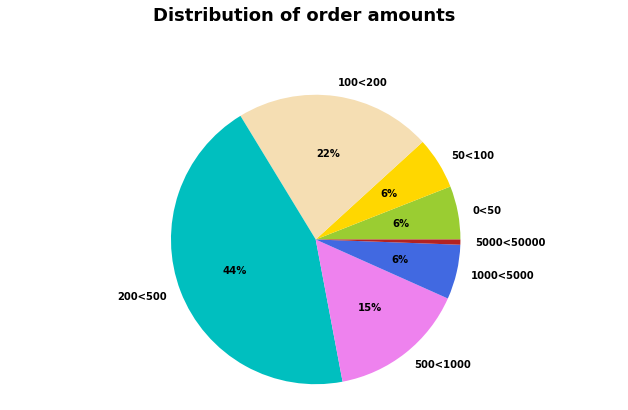

In [39]:
# purchase count
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)

# number of transactions per price range       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha='center', fontsize = 18);

The above shows that 44% of transactions fall in the range of £200-500.

### Exploring Product Categories

Utilising NLP methods, product descriptions can be analysed.

In [40]:
import nltk
nltk.download('averaged_perceptron_tagger')

is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, column = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  
    keywords_select = dict()
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    
    for s in dataframe[column]:
        if pd.isnull(s): 
            continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Number of keywords in variable '{}': {}".format(column, len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/charlottefettes/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [41]:
products = pd.DataFrame(df['Description'].unique()).rename(columns = {0:'Description'})

In [42]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(products)

Number of keywords in variable 'Description': 1477


In [43]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

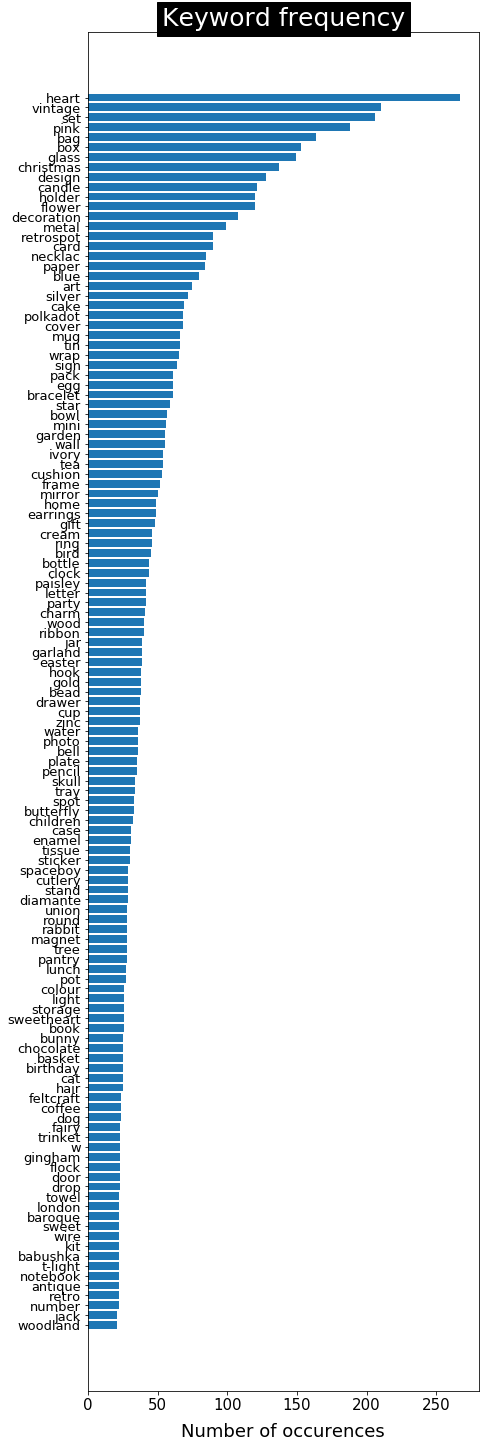

In [44]:
#create representation of most common keywords
list_sorted = sorted(list_products, key = lambda x:x[1], reverse = True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in list_sorted[:125]]
x_axis = [k for k,i in enumerate(list_sorted[:125])]
x_label = [i[0] for i in list_sorted[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Number of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Keyword frequency", bbox={'facecolor':'k', 'pad':5}, color='w', fontsize = 25)
plt.show()

From product descriptions, 1,477 keywords were identified. The most common - heart - appears in about 250 products.

Not all of these common words provide value, e.g. 'w'. These can be ignored, as well as words that are not very common (ones that are only in 12 or fewer products). In addition, symbols (such as + or /) will be removed.

In [50]:
list_products = []
for k, v in count_keywords.items():
    word = keywords_select[k]
    
    #ignore colours
    #if word in ['pink', 'blue', 'tag', 'green', 'purple', 'turquoise', 'orange']: 
      #  continue
    #ignore words with less than 3 letters or count less than 10
    if len(word) < 3 or v < 13: 
        continue
    
    if ('+' in word) or ('/' in word): 
        continue
    
    list_products.append([word, v])
    
list_products.sort(key = lambda x:x[1], reverse = True)
print('Retained words:', len(list_products))

Retained words: 195


These keywords will now be used to create a product category variable through clustering. A matrix will be created, with each row being a product vector, indicating which keywords are present in the product description.

In order to assist in clustering these products into categories, the price range category of the item will be included

In [51]:
product_lst = df['Description'].unique()

X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), product_lst))

In [52]:
#create unit price range variable
threshold = [0, 1, 2, 3, 5, 10, 100]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '>{}'.format(threshold[i])
    else:
        col = '{}<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(product_lst):
    price = df[df['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while price > threshold[j]:
        j+=1
        if j == len(threshold): 
            break
    X.loc[i, label_col[j-1]] = 1

In [53]:
print("{:<8} {:<20} \n".format('range', 'number of products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '>{}'.format(threshold[i])
    else:
        col = '{}<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

range    number of products   
--------------------
0<1         963                 
1<2         1009                
2<3         673                 
3<5         608                 
5<10        468                 
10<100      144                 
>100        7                   


Using K Means, a range of cluster numbers will be evaluated using the silhouette score. The number of clusters with the highest silhouette score will be chosen. Clusters will then be created and evaluated to see if they would make a valuable feature to include in the dataset for the purposes of clustering and classification.

For n_clusters = 3 The average silhouette_score is : 0.09419355601469266
For n_clusters = 4 The average silhouette_score is : 0.11792779150669064
For n_clusters = 5 The average silhouette_score is : 0.13688727670542858
For n_clusters = 6 The average silhouette_score is : 0.13999916327964324
For n_clusters = 7 The average silhouette_score is : 0.13827944321759691
For n_clusters = 8 The average silhouette_score is : 0.12481153794185998
For n_clusters = 9 The average silhouette_score is : 0.12805570396457158
For n_clusters = 10 The average silhouette_score is : 0.1059469385734452


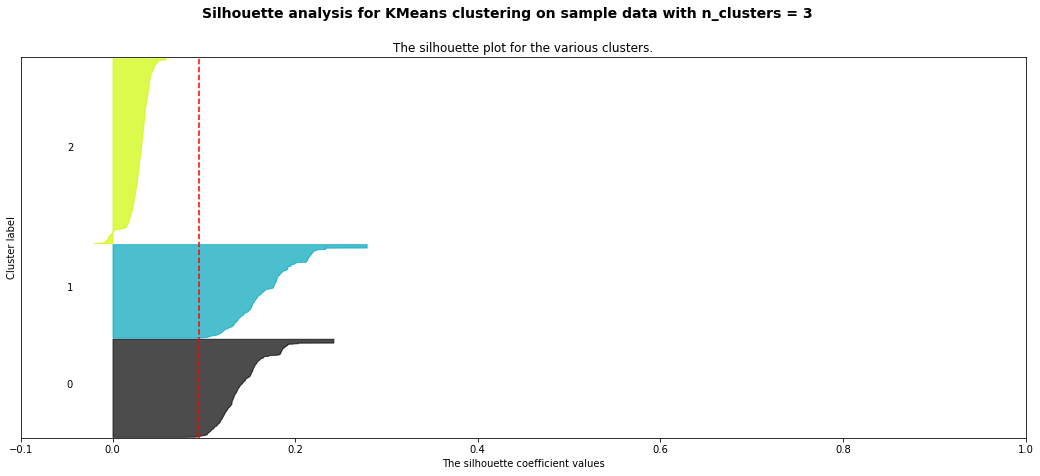

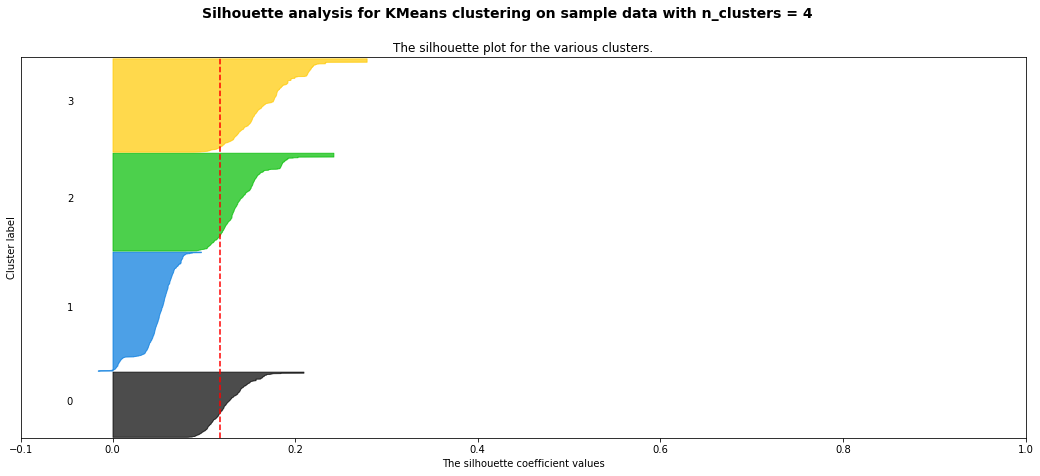

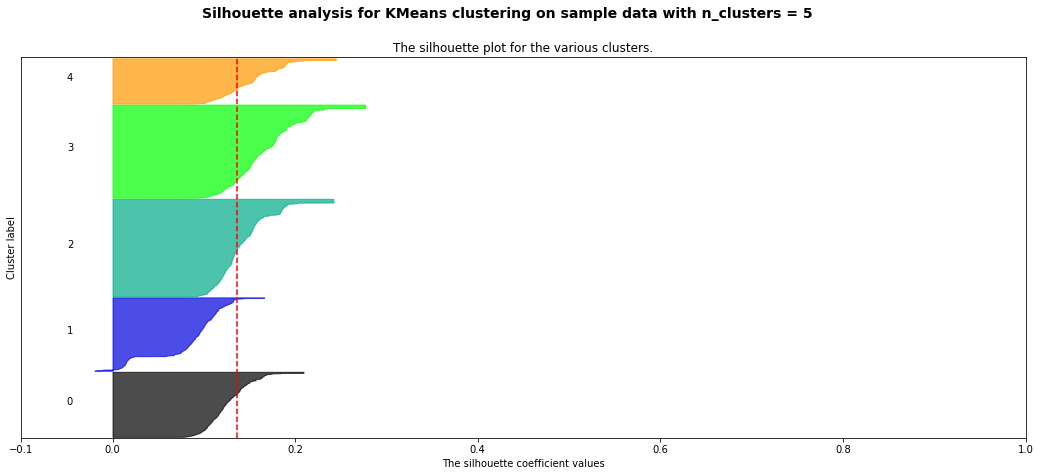

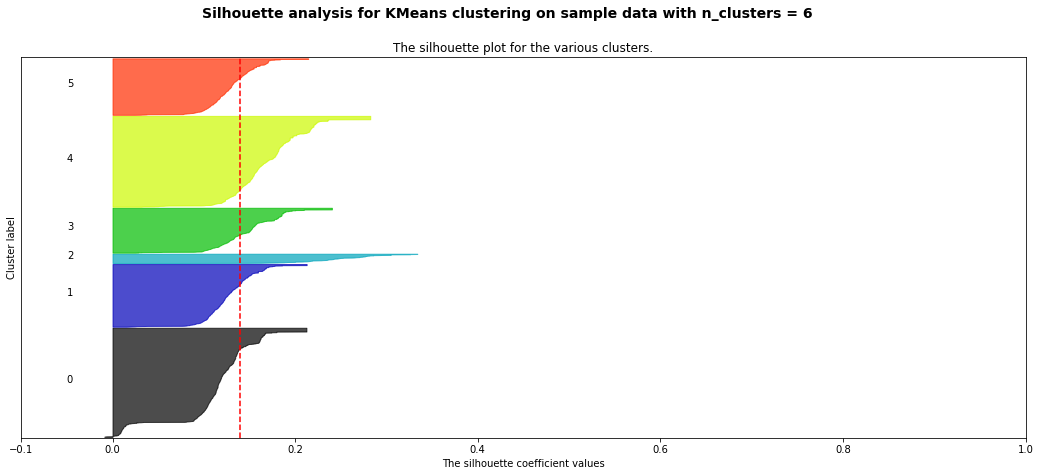

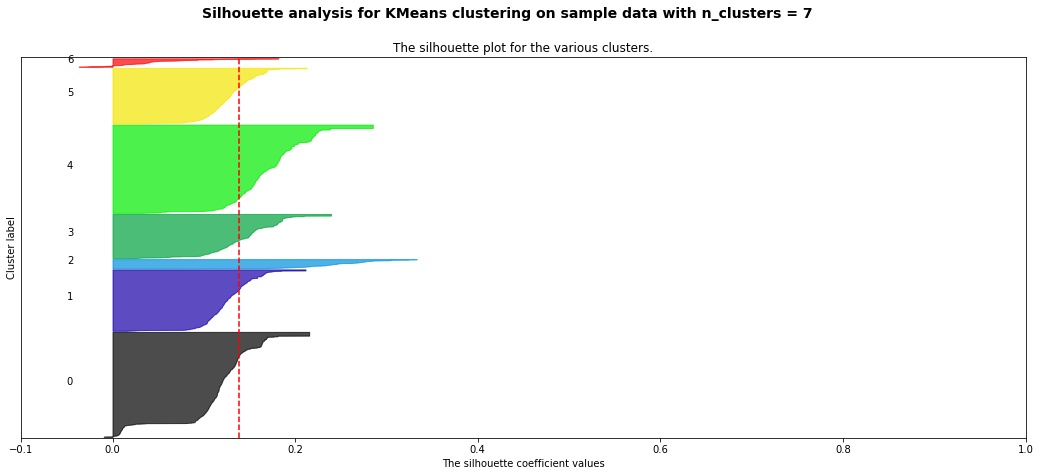

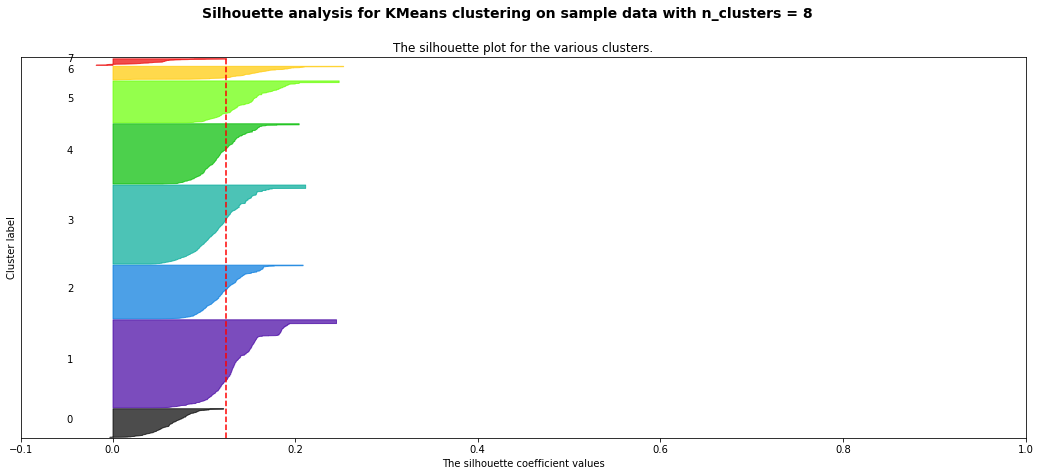

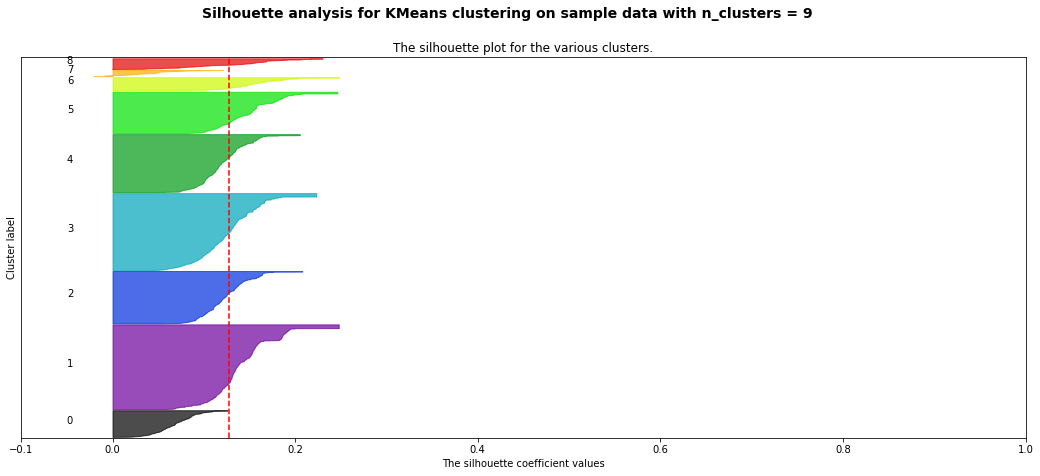

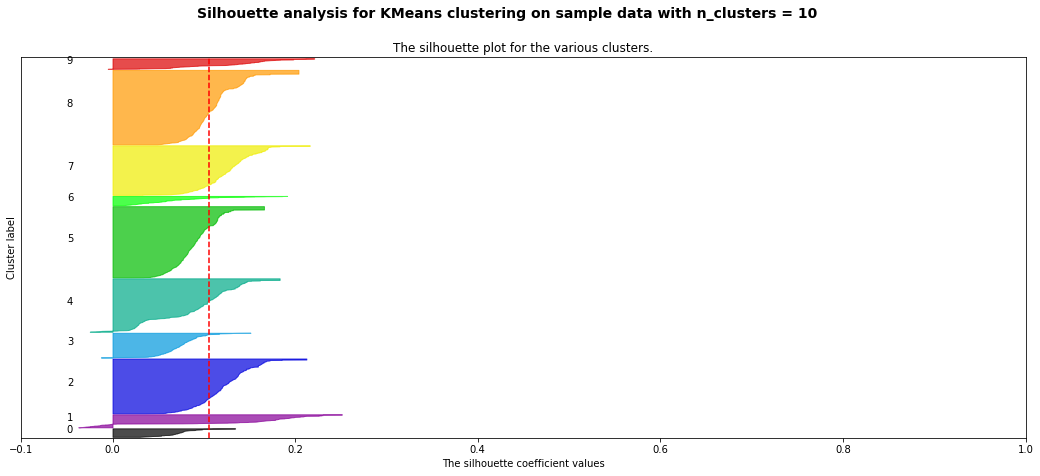

In [54]:
for n_clusters in range(3,11):
    # Create subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialise clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    clusters = clusterer.fit_predict(X)

    # silhouette_score gives average value for all samples
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, clusters)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, clusters)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[clusters == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label silhouette plots with cluster numbers at middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # vertical line for average silhouette score of all values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

From the silhouette scores above, 6 clusters appears to be optimal, although the value is still quite low indicating overlap.

In [55]:
#create clusters
n_clusters = 6
km = KMeans(n_clusters = n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = km.fit_predict(X)
silhouette_avg = silhouette_score(X, clusters)
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.13999916327964324


In [56]:
#number of products per cluster
pd.Series(clusters).value_counts()

0    1131
4     942
1     650
5     586
3     466
2      97
dtype: int64

In order to evaluate the clusters, a number of methods will be used: 
1. Intra-cluster silhouette score will provide information on the quality of the clustering.
2. Word Clouds will indicate the importance of different words per cluster, giving an indication of what each cluster represents
3. Principal Component Analysis

In [57]:
#function to create intra-cluster plots
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    #plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        #color = cm.spectral(float(i) / n_clusters) facecolor=color, edgecolor=color,       
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, alpha=0.8)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
       
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

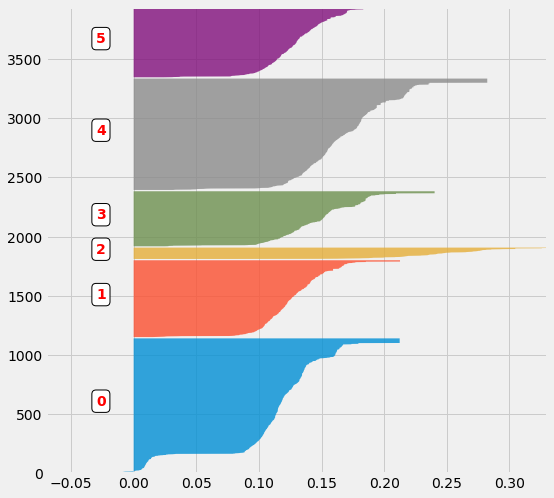

In [58]:
# create plot for individual cluster silhouette scores
sample_silhouette_values = silhouette_samples(X, clusters)
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

In [59]:
#counting number of word occurrences per cluster
product_lst_df = pd.DataFrame(product_lst)
words_lst = [word for (word, occurrence) in list_products]

occurrence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    cluster_lst = product_lst_df.loc[clusters == i]
    
    for word in words_lst:
        #if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: 
         #   continue
        
        occurrence[i][word] = sum(cluster_lst.loc[:, 0].str.contains(word.upper()))

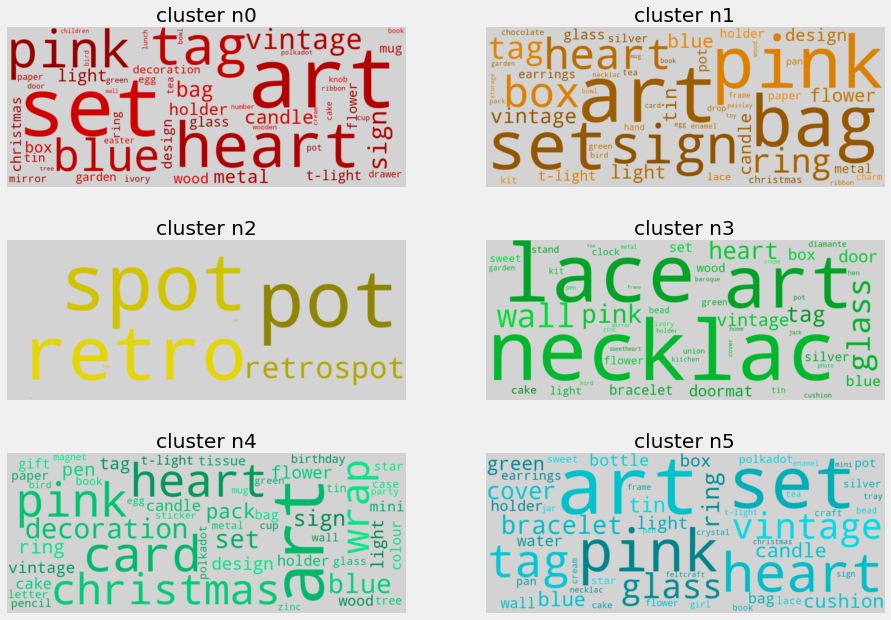

In [60]:
#function for word cloud
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def make_wordcloud(lst, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = lst[0:50]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster n{}'.format(increment-1))

#generate word clouds for clusters
fig = plt.figure(1, figsize=(14,14))
color = [0, 25, 40, 95, 110, 130, 160, 280, 330]
for i in range(n_clusters):
    list_cluster_occurrences = occurrence[i]

    tone = color[i]
    lst = []
    for key, value in list_cluster_occurrences.items():
        lst.append([key, value])
    
    lst.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(lst, i+1)

From this representation, there is clearly some overlap in terms of keywords. However, it should be considered in combination with other keywords of the product description (as it is the vector that is being evaluated, not just the word). 

The clusters do appear to have different characteristics. For example, cluster 2 seems to have furniture- and kitchen-related aspects, such as 'diner', 'stand', 'cabinet' and 'vintage'. Whereas, cluster 0 has a lot of keywords related to decorative items such as 'pot', 'cover' and 'candle', and cluster 1 seems to be associated with gifting, such as 'christmas', 'card' and 'wrap'.

In [61]:
pca = PCA()
pca.fit(X)
pca_samples = pca.transform(X)

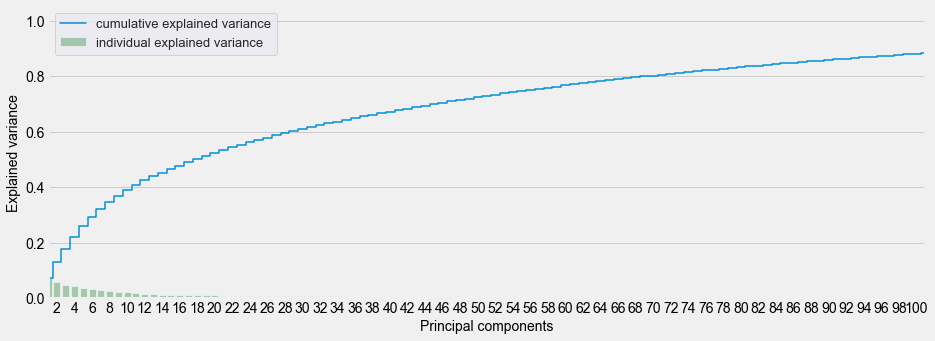

In [62]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(X.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1, X.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

This plot shows that around 100 components from the X dataframe are needed to explain 90% of the variance. 

From the above:
+ Product category clusters are very unbalanced: 3,486 products in cluster 0, 295 in cluster 1, and 97 in cluster 1
+ From the word cloud visualisations, again it shows quite an imbalance - there a significantly more keywords in cluster 0. And from examining the words, there does not appear to be any particular meaning or pattern to these clusters based on keywords
+ PCA shows that to explain most of the variance of the data a very high number of components are necessary.

Based on the above observations, the decision has been made not to use these product categories as features, and instead try one-hot encoding products. Although this will result in high dimensionality, it should hopefully provide models with more meaningful input.



In [63]:
pca = PCA(n_components = 100)
matrix_9D = pca.fit_transform(X)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

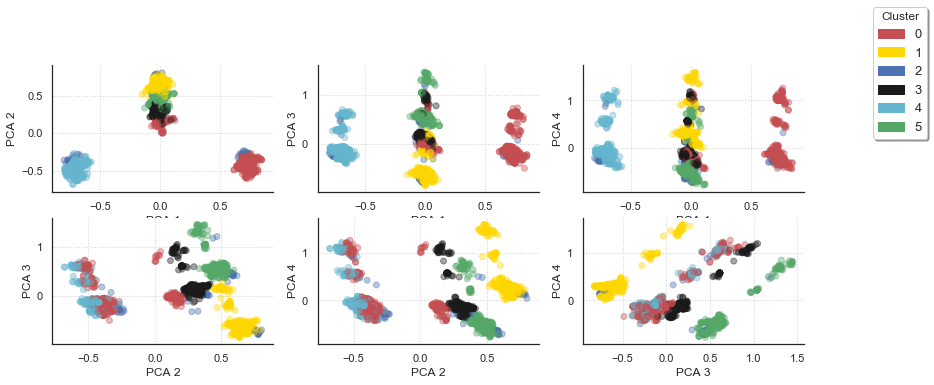

In [64]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: 
            break
    if increment == 9: 
        break
        

comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster',
           shadow = True, frameon = True, framealpha = 1,fontsize = 13, 
           bbox_transform = plt.gcf().transFigure) #facecolor = 'lightgrey',

plt.tight_layout()

These plots show that when comparing different principal components, there is always separation between at least some of the clusters, and samples within clusters do appear to be grouped - not necessarily with all other samples within the cluster but in groups within the cluster. This will obviously vary between the principal components, with different distributions for different clusters between principal components.

From the above, it appears that categorisation of products into these 6 clusters is a valid categorisation to use.

In [65]:
#creating categories for products based on clusters
cat_prod = dict()
for key, val in zip (product_lst, clusters):
    cat_prod[key] = val 

df['categ_product'] = df.loc[:, 'Description'].map(cat_prod)
df[['InvoiceNo', 'Description', 
    'categ_product']][:10]

InvoiceNo                          Description  categ_product
0    536365   WHITE HANGING HEART T-LIGHT HOLDER              1
1    536365                  WHITE METAL LANTERN              5
2    536365       CREAM CUPID HEARTS COAT HANGER              5
3    536365  KNITTED UNION FLAG HOT WATER BOTTLE              5
4    536365       RED WOOLLY HOTTIE WHITE HEART.              5
5    536365         SET 7 BABUSHKA NESTING BOXES              3
6    536365    GLASS STAR FROSTED T-LIGHT HOLDER              5
7    536366               HAND WARMER UNION JACK              1
8    536366            HAND WARMER RED POLKA DOT              0
9    536367        ASSORTED COLOUR BIRD ORNAMENT              0

In [66]:
#separate product category into columns and fill how much spent on that
for i in range(6):
    col = 'cat_{}'.format(i)
    temp = df[df['categ_product'] == i]
    price = temp['UnitPrice'] * (temp.Quantity - temp.QuantityCancelled)
    price = price.apply(lambda x: x if x > 0 else 0)
    df.loc[:, col] = price
    df[col].fillna(0, inplace = True)
    
df.head(10)

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
7    536366     22633               HAND WARMER UNION JACK         6   
8    536366     22632            HAND WARMER RED POLKA DOT         6   
9    536367     84879        ASSORTED COLOUR BIRD ORNAMENT        32   

          InvoiceDate  UnitPrice CustomerID         Country  \
0 2010-12-01 08:26:00       2.55      17850  United Kingdom   
1 2010-12-01 08:26:00       3.39      17850  United Kingdom   
2 2010-12-01 08:26:00       2.75      17850  United Kingdom   
3 2010-12-01 08:26:00       3.39      17850  United Kingdom   
4 2010-12-01 08:26:00       3.39      17850  United Kingdom   
5 2010-12-01 08:26:00       7.65      17850  United Kingdom   
6 2010-12-01 08:26:00       4.25      17850  United Kingdom   
7 2010-12-01 08:28:00       1.85      17850  United Kingdom   
8 2010-12-01 08:28:00       1.85      17850  United Kingdom   
9 2010-12-01 08:34:00       1.69      13047  United Kingdom   

   QuantityCancelled  TotalPrice  categ_product  cat_0  cat_1  cat_2  cat_3  \
0                  0       15.30              1   0.00   15.3    0.0    0.0   
1                  0       20.34              5   0.00    0.0    0.0    0.0   
2                  0       22.00              5   0.00    0.0    0.0    0.0   
3                  0       20.34              5   0.00    0.0    0.0    0.0   
4                  0       20.34              5   0.00    0.0    0.0    0.0   
5                  0       15.30              3   0.00    0.0    0.0   15.3   
6                  0       25.50              5   0.00    0.0    0.0    0.0   
7                  0       11.10              1   0.00   11.1    0.0    0.0   
8                  0       11.10              0  11.10    0.0    0.0    0.0   
9                  0       54.08              0  54.08    0.0    0.0    0.0   

   cat_4  cat_5  
0    0.0   0.00  
1    0.0  20.34  
2    0.0  22.00  
3    0.0  20.34  
4    0.0  20.34  
5    0.0   0.00  
6    0.0  25.50  
7    0.0   0.00  
8    0.0   0.00  
9    0.0   0.00

In [67]:
#combine all item rows per invoice no.
temp = df.groupby(by = ['CustomerID', 'InvoiceNo'], as_index = False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
n_clusters = 6
# percentage of price of order by product category
for i in range(n_clusters):
    col = 'cat_{}'.format(i) 
    temp = df.groupby(by = ['CustomerID', 'InvoiceNo'], as_index = False)[col].sum()
    basket_price.loc[:, col] = temp 

# date of  order
df['InvoiceDate_int'] = df['InvoiceDate'].astype('int64')
temp = df.groupby(by = ['CustomerID', 'InvoiceNo'], as_index = False)['InvoiceDate_int'].mean()
df.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# remove orders with basket price less than 0
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.head()

CustomerID InvoiceNo  Basket Price   cat_0   cat_1  cat_2   cat_3  cat_4  \
1      12347    537626        711.79  187.20   83.40   22.5  124.44  23.40   
2      12347    542237        475.39  156.25   35.40   47.9    0.00  84.34   
3      12347    549222        636.25  369.15   35.70   35.4    0.00  81.00   
4      12347    556201        382.52   74.40   78.06    0.0   19.90  41.40   
5      12347    562032        584.91  147.95  119.70    0.0   97.80  61.30   

    cat_5                   InvoiceDate  
1  270.85 2010-12-07 14:57:00.000001024  
2  151.50 2011-01-26 14:29:59.999999744  
3  115.00 2011-04-07 10:42:59.999999232  
4  168.76 2011-06-09 13:01:00.000000256  
5  158.16 2011-08-02 08:48:00.000000000

As the purpose is to be able to cluster new customers, an additional temporary feature will be created a number of steps will be taken next:
1. A single row per customer will be created that considers the minimum, maximum and mean basket price, and the proportion of their transactions that fall in each product category
2. A temporary feature will be created that gives the number of days since their first purchase based on the latest date in the dataset
3. Those customers that have their first purchase less than or equal to 60 days (2 months) will be separated from the dataset and will become the test set

In [68]:
# combining all customer orders for each customer id into single row
user_transactions = basket_price.groupby(by = ['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])

for i in range(n_clusters):
    col = 'cat_{}'.format(i)
    user_transactions.loc[:, col] = basket_price.groupby(by = ['CustomerID'])[col].sum() /\
    user_transactions['sum'] * 100
    
user_transactions.reset_index(drop = False, inplace = True)
user_transactions.head()

CustomerID  count      min      max         mean      sum      cat_0  \
0      12347      7   224.82  1294.32   615.714286  4310.00  30.523202   
1      12348      4   187.44   652.80   359.310000  1437.24  52.461663   
2      12349      1  1457.55  1457.55  1457.550000  1457.55  40.187987   
3      12350      1   294.40   294.40   294.400000   294.40  55.027174   
4      12352      6   104.35   296.50   210.901667  1265.41  34.647268   

       cat_1      cat_2      cat_3      cat_4      cat_5  
0  19.573086   2.454756   7.604176  11.237123  28.607657  
1   0.000000   2.905569   0.000000  44.632768   0.000000  
2  11.452094  16.239580  19.965010   3.342595   8.812734  
3  31.691576   6.929348   0.000000   6.351902   0.000000  
4   7.675773   1.173533  27.698532   2.449799  26.355094

In [69]:
#find number of days since first purchase
latest_date = basket_price['InvoiceDate'].max().date()

first_purchase = pd.DataFrame(basket_price.groupby(by = ['CustomerID'])['InvoiceDate'].min())

first_pur = first_purchase.applymap(lambda x: (latest_date - x.date()).days)

user_transactions.loc[:, 'First Purchase'] = first_pur.reset_index(drop = False)['InvoiceDate']
user_transactions.head()

CustomerID  count      min      max         mean      sum      cat_0  \
0      12347      7   224.82  1294.32   615.714286  4310.00  30.523202   
1      12348      4   187.44   652.80   359.310000  1437.24  52.461663   
2      12349      1  1457.55  1457.55  1457.550000  1457.55  40.187987   
3      12350      1   294.40   294.40   294.400000   294.40  55.027174   
4      12352      6   104.35   296.50   210.901667  1265.41  34.647268   

       cat_1      cat_2      cat_3      cat_4      cat_5  First Purchase  
0  19.573086   2.454756   7.604176  11.237123  28.607657             367  
1   0.000000   2.905569   0.000000  44.632768   0.000000             358  
2  11.452094  16.239580  19.965010   3.342595   8.812734              18  
3  31.691576   6.929348   0.000000   6.351902   0.000000             310  
4   7.675773   1.173533  27.698532   2.449799  26.355094             296

In [209]:
test = user_transactions[user_transactions['First Purchase'] <= 60]
train = user_transactions[user_transactions['First Purchase'] > 60]

In [71]:
test.shape, train.shape

((613, 13), (3711, 13))

In [72]:
n1 = train[train['count'] == 1].shape[0]
n2 = train.shape[0]
print("No. customers with single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

No. customers with single purchase: 1054/3711  (28.40%)


## Creation of Customer Categories Using Clustering

The purpose here is to create customer classes through clustering with the training set (known customers). A classification model can then be developed that can predict which class a new customer should be in based on their purchase behaviour. 

By creating the categories (labels), the problem becomes a supervised learning problem, which enables the evaluation of the resulting model in predicting which category a customer should be allocated to. By following this method, it should hopefully increase the likelihood significantly of customers being allocated to appropriate clusters, enabling the service provider to better cater and respond to each individual customer's needs, increasing customer loyalty to the service provider, and thus sales.

First, features will be selected for clustering:
+ As new customers will no doubt have a lower sum of sales, given fewer transactions, 'sum' will be dropped
+ FirstPurchase will be dropped as it would obviously be lower, and not modelled, for newer customers
+ Count will also be dropped. This will at least partially be accounted for in 'mean', and, although as shown above, 28% of customers only have a single transaction, for new customers this does not have the same meaning - it is due to being new, whereas for other customers, depending on when their purchase occurred, it could indicate dropout - and new customers may end up after some time having a high number of transactions
+ CustomerID will also be dropped for clustering, as this is just an idenitfier, and does not reflect purchasing behaviour

A selection of clustering algorithms - from the main clustering algorithm types (connectivity, centroid, distribution and density models) to see which type is best suited to this data - will be tested, using Silhouette Coefficient, Calinski-Harabasz Index and Davies-Bouldin Index, as well as PCA visualisation to evaluate the clustering quality. The algorithms used will include:
+ K Means & Mean-Shift - a centroid model, where the notion of similarity is derived by the closeness of a data point to the centroid of the clusters
+ Expectation–Maximization (EM) Clustering using Gaussian Mixture Models (GMM) - a distribution model, based on the notion of how probable it is that all data points in the cluster belong to the same distribution
+ Agglomerative Hierarchical Clustering - a connectivity model, based on the notion that the data points closer in data space exhibit more similarity to each other than the data points lying further away
+ DBSCAN - a density model, which searches for areas of varied density of data points in the data space, isolates various different density regions and assigns the data points within these regions in the same cluster.

In [73]:
train.head()

CustomerID  count     min      max        mean      sum      cat_0  \
0      12347      7  224.82  1294.32  615.714286  4310.00  30.523202   
1      12348      4  187.44   652.80  359.310000  1437.24  52.461663   
3      12350      1  294.40   294.40  294.400000   294.40  55.027174   
4      12352      6  104.35   296.50  210.901667  1265.41  34.647268   
5      12353      1   89.00    89.00   89.000000    89.00  57.752809   

       cat_1     cat_2      cat_3      cat_4      cat_5  First Purchase  
0  19.573086  2.454756   7.604176  11.237123  28.607657             367  
1   0.000000  2.905569   0.000000  44.632768   0.000000             358  
3  31.691576  6.929348   0.000000   6.351902   0.000000             310  
4   7.675773  1.173533  27.698532   2.449799  26.355094             296  
5  19.887640  0.000000  22.359551   0.000000   0.000000             204

In [74]:
#feature selection 
train_df = train.copy(deep=True)
train_df = train_df.drop(columns=['sum','count','CustomerID','First Purchase'], axis=1)

In [75]:
matrix = train_df.as_matrix()

#scale data
scaler = StandardScaler()
scaler.fit(matrix)
scaled_train = scaler.transform(matrix)

PCA can be used to reduce the dimensionality down to a number of components that capture the greatest amount of variance in the data, and enable the scatter visualisation between principal components of the resulting clusters. If the clustering is of a good quality, the visualisations will show clearly defined clusters. 

In [76]:
pca = PCA()
pca.fit(scaled_train)
pca_samples = pca.transform(scaled_train)

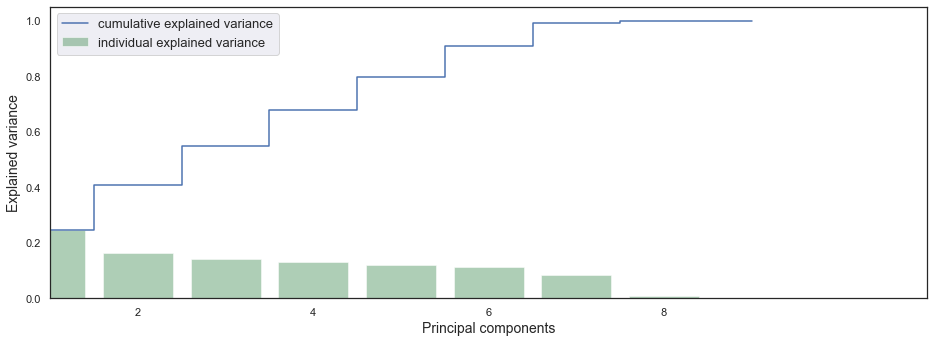

In [77]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

7 principal components captures approximately 90% of the variance, and so will be the n_components selected.

### Applying and Evaluating Clustering Algorithms

A number of methods will be used to evaluate the resulting clustering: 
+ PCA visualisation
+ As there is no ground truth labels, intrinsic measures will be used to evaluate cluster quality and compare algorithm results, including: Silhouette Coefficient, Calinski-Harabasz Index and Davies-Bouldin Index

In [78]:
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score

#function to print intrinsic measures scores
def eval_measures(matrix, clusters):
    sil_score = silhouette_score(matrix, clusters)
    cal_score = metrics.calinski_harabasz_score(matrix, clusters)
    dav_score = davies_bouldin_score(scaled_train, clusters)
    print('Average Silhouette Score: ', sil_score)
    print('Calinski-Harabasz Index: ', cal_score)
    print('Davies-Bouldin Index: ', dav_score)
    return sil_score, cal_score, dav_score

In [79]:
import matplotlib.patches as mpatches

#function to plot pca visualisations
def pca_vis(data, clusters, n_clusters):
    
    pca = PCA(n_components=7)
    matrix_3D = pca.fit_transform(data)
    mat = pd.DataFrame(matrix_3D)
    mat['cluster'] = pd.Series(clusters)
    
    sns.set_style("white")
    sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

    LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan',
                       9:'orange',10:'yellow', 11:'tomato', 12:'seagreen', 13:'dimgray', 14:'papayawhip', 15:'thistle', 16:'crimson', 17:'lightgreen', 18:'olive'}
    label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

    fig = plt.figure(figsize = (12,10))
    increment = 0
    for ix in range(7):
        for iy in range(ix+1, 7):   
            increment += 1
            ax = fig.add_subplot(4,3,increment)
            plt.subplots_adjust(hspace = 0.5)
            ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
            plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
            plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
            ax.yaxis.grid(color='lightgray', linestyle=':')
            ax.xaxis.grid(color='lightgray', linestyle=':')
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
        
            if increment == 12: 
                break
        if increment == 12: 
            break    

    comp_handler = []
    for i in range(n_clusters):
        comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

    plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
               title='Cluster', 
               shadow = True, frameon = True, framealpha = 1,
               fontsize = 13, bbox_transform = plt.gcf().transFigure) 

    plt.tight_layout()

#### KMeans

In [80]:
for n_clusters in range(3,20):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
    kmeans.fit(scaled_train)
    clusters = kmeans.predict(scaled_train)
    silhouette_avg = silhouette_score(scaled_train, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.12434068983617856
For n_clusters = 4 The average silhouette_score is : 0.1399331020058633
For n_clusters = 5 The average silhouette_score is : 0.14601394726337766
For n_clusters = 6 The average silhouette_score is : 0.16206227742561768
For n_clusters = 7 The average silhouette_score is : 0.17603819894315767
For n_clusters = 8 The average silhouette_score is : 0.18349465157515155
For n_clusters = 9 The average silhouette_score is : 0.19674643016511117
For n_clusters = 10 The average silhouette_score is : 0.20185220661041528
For n_clusters = 11 The average silhouette_score is : 0.1736610464458914
For n_clusters = 12 The average silhouette_score is : 0.17858272228181368
For n_clusters = 13 The average silhouette_score is : 0.17744570161938697
For n_clusters = 14 The average silhouette_score is : 0.1802614214713621
For n_clusters = 15 The average silhouette_score is : 0.1845734329956133
For n_clusters = 16 The average silhouette_score 

In [81]:
#create clusters with n_clusters=10
km = KMeans(init='k-means++', n_clusters = 10, n_init=100)
km_clusters = km.fit_predict(scaled_train)

In [82]:
#customers per cluster
pd.DataFrame(pd.Series(km_clusters).value_counts(), columns = ['number of customers']).T

6    8    9    5    0    2    3    1   7  4
number of customers  1650  423  408  308  286  257  204  156  11  8

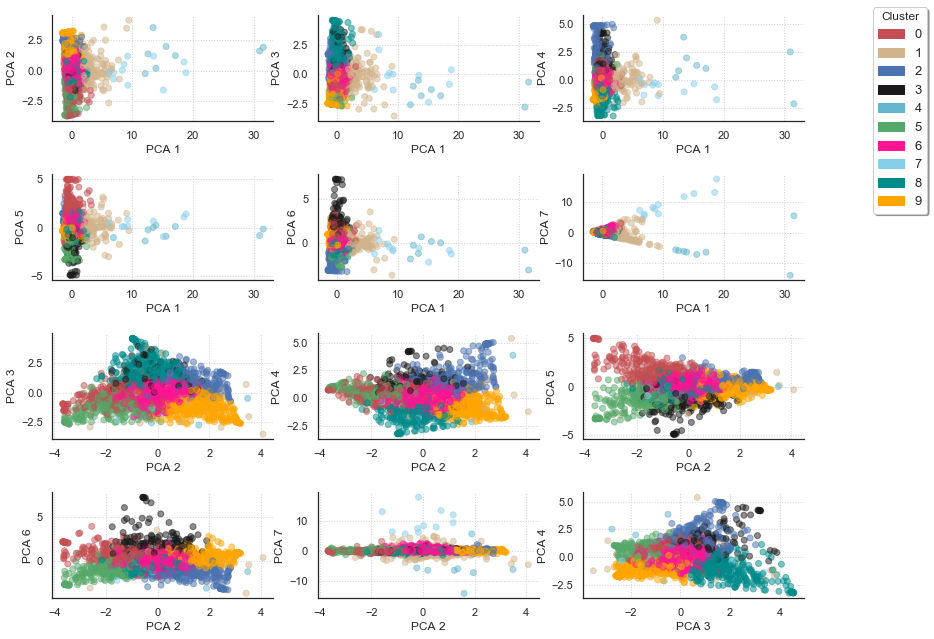

In [83]:
#pca
pca_vis(scaled_train, km_clusters, 10)

In [84]:
#clustering performance measures
km_sil, km_cal, km_dav = eval_measures(scaled_train, km_clusters)

Average Silhouette Score:  0.20429329673652427
Calinski-Harabasz Index:  594.4994502406398
Davies-Bouldin Index:  1.1690721269555984


In [85]:
#scores into df for later comparison
cluster_eval = pd.DataFrame(columns=['Algorithm','SilhouetteScore','CalinskiHarabaszIndex','DaviesBouldinIndex'])
cluster_eval = cluster_eval.append({'Algorithm':'KMeans', 'CalinskiHarabaszIndex': km_cal, 'DaviesBouldinIndex':km_dav,'SilhouetteScore':km_sil}, ignore_index=True) 

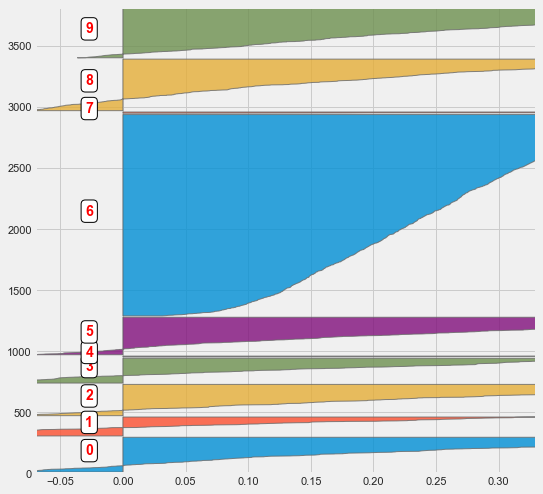

In [86]:
# create plot for individual cluster silhouette scores
sample_silhouette_values = silhouette_samples(scaled_train, km_clusters)
graph_component_silhouette(10, [-0.07, 0.33], len(scaled_train), sample_silhouette_values, km_clusters)

#### Expectation–Maximization (EM) Clustering using Gaussian Mixture Models (GMM)

In [87]:
from sklearn.mixture import GaussianMixture
for n_clusters in range(3,20):
    gmm = GaussianMixture(n_components=n_clusters, init_params='random')
    gmm.fit(scaled_train)
    gmm_clusters = gmm.predict(scaled_train)
    silhouette_avg = silhouette_score(scaled_train, gmm_clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.036245460175861756
For n_clusters = 4 The average silhouette_score is : 0.023320833451554026
For n_clusters = 5 The average silhouette_score is : -0.024680783144416827
For n_clusters = 6 The average silhouette_score is : -0.04786681398370827
For n_clusters = 7 The average silhouette_score is : -0.04648516954154122
For n_clusters = 8 The average silhouette_score is : -0.06558295927159084
For n_clusters = 9 The average silhouette_score is : -0.0944900239992123
For n_clusters = 10 The average silhouette_score is : -0.09106779055800004
For n_clusters = 11 The average silhouette_score is : -0.08761915128383478
For n_clusters = 12 The average silhouette_score is : -0.09848331599882487
For n_clusters = 13 The average silhouette_score is : -0.11211718048275424
For n_clusters = 14 The average silhouette_score is : -0.10540739733642374
For n_clusters = 15 The average silhouette_score is : -0.114537115454495
For n_clusters = 16 The average si

In [88]:
#create clusters with n_clusters=3
gmm = GaussianMixture(n_components = 3, init_params='random')
gmm_clusters = gmm.fit_predict(scaled_train)

In [89]:
#customers per cluster
pd.DataFrame(pd.Series(gmm_clusters).value_counts(), columns = ['number of customers']).T

2     0    1
number of customers  1915  1613  183

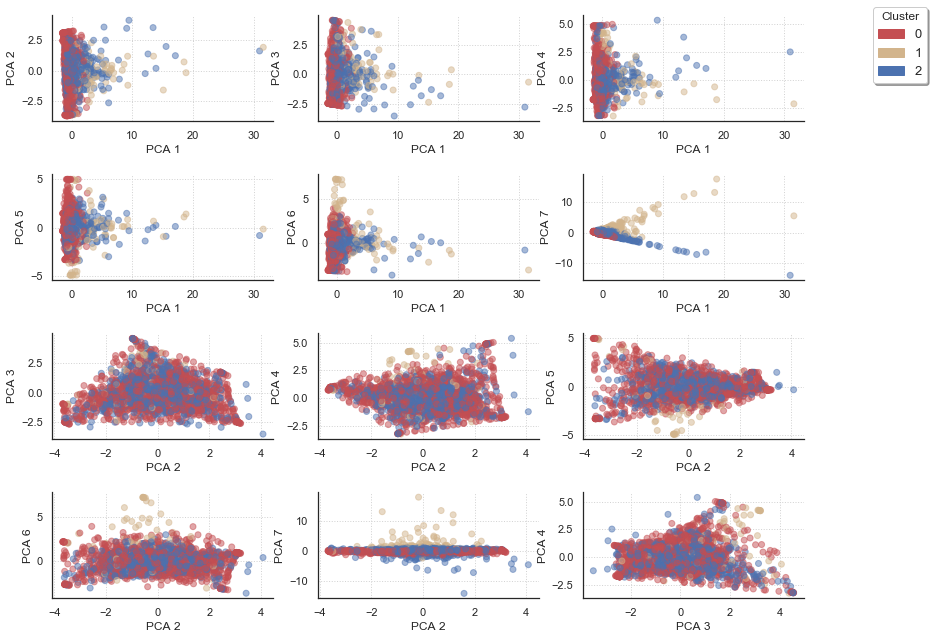

In [90]:
#pca
pca_vis(scaled_train, gmm_clusters, 3)

In [91]:
#clustering performance measures
gmm_sil, gmm_cal, gmm_dav = eval_measures(scaled_train, gmm_clusters)

Average Silhouette Score:  0.024468520136004764
Calinski-Harabasz Index:  105.33597531958945
Davies-Bouldin Index:  6.808886167737705


In [92]:
cluster_eval = cluster_eval.append({'Algorithm':'GaussianMixture', 'CalinskiHarabaszIndex':gmm_cal, 'DaviesBouldinIndex':gmm_dav,'SilhouetteScore':gmm_sil}, ignore_index=True) 

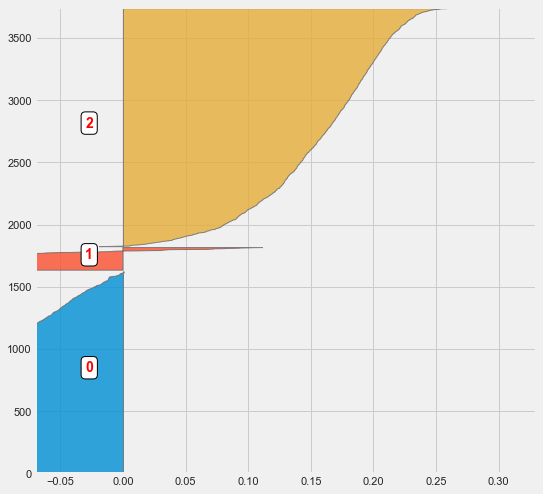

In [93]:
# create plot for individual cluster silhouette scores
sample_silhouette_values = silhouette_samples(scaled_train, gmm_clusters)
graph_component_silhouette(3, [-0.07, 0.33], len(scaled_train), sample_silhouette_values, gmm_clusters)

#### Agglomerative Hierarchical Clustering

In [94]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

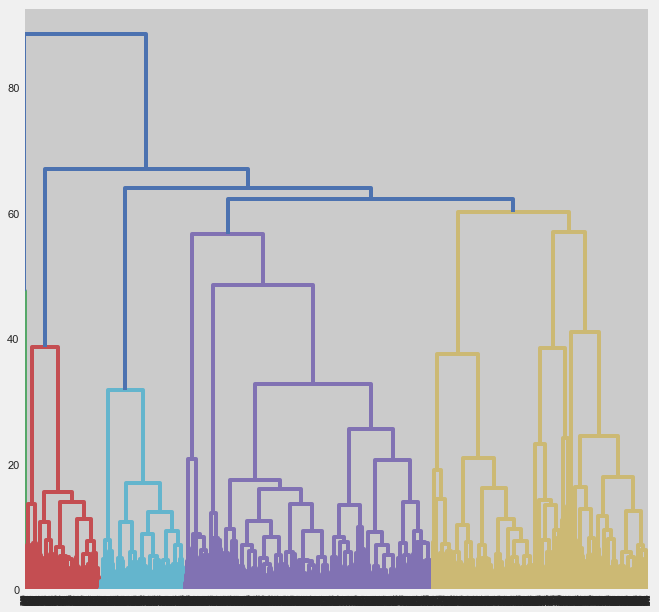

In [95]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
dendrogram = sch.dendrogram(sch.linkage(scaled_train, method='ward'))

From the above, 10 clusters appears to be the most appropriate choice (2 was tested, but produced very unbalanced clusters).

In [96]:
ahc_model = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')
ahc_model.fit(scaled_train)
ahc_labels = ahc_model.labels_

In [97]:
#customers per cluster
pd.DataFrame(pd.Series(ahc_labels).value_counts(), columns = ['number of customers']).T

4    5    3    0    2    6    7   8   1  9
number of customers  1247  603  505  476  441  204  147  74  10  4

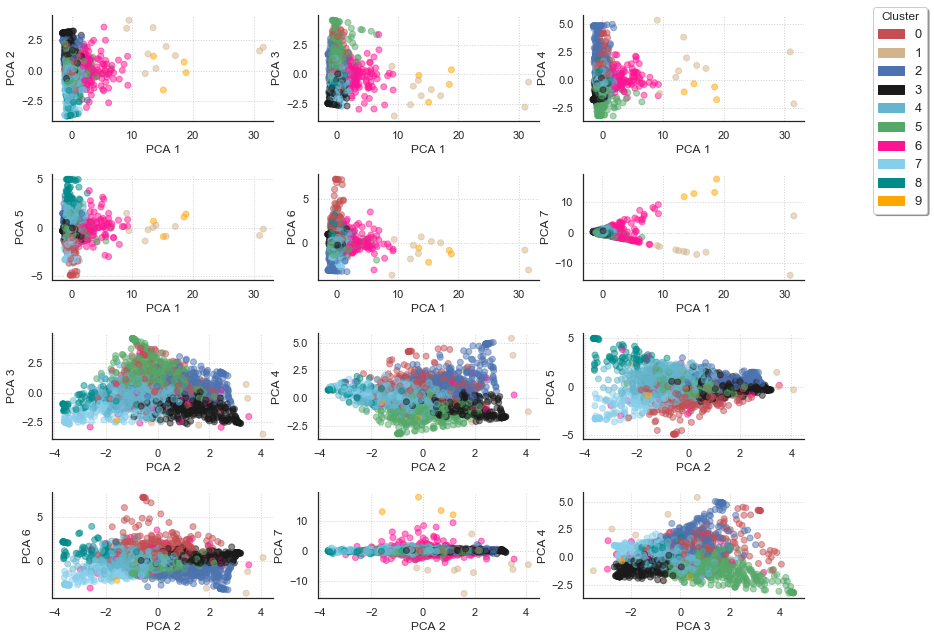

In [98]:
#pca
pca_vis(scaled_train, ahc_labels, 10)

In [99]:
#clustering performance measures
ahc_sil, ahc_cal, ahc_dav = eval_measures(scaled_train, ahc_labels)

Average Silhouette Score:  0.13019914125719437
Calinski-Harabasz Index:  453.8956351454151
Davies-Bouldin Index:  1.2768190078185389


In [100]:
cluster_eval = cluster_eval.append({'Algorithm':'Agglomerative Hierarchical', 'CalinskiHarabaszIndex':ahc_cal,'DaviesBouldinIndex':ahc_dav,'SilhouetteScore':ahc_sil}, ignore_index=True) 

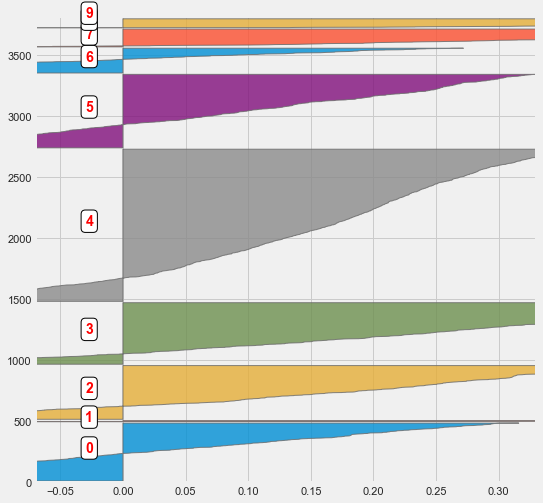

In [101]:
# create plot for individual cluster silhouette scores
sample_silhouette_values = silhouette_samples(scaled_train, ahc_labels)
graph_component_silhouette(10, [-0.07, 0.33], len(scaled_train), sample_silhouette_values, ahc_labels)

#### DBSCAN

In [105]:
from sklearn.cluster import DBSCAN

In [106]:
db = DBSCAN(eps=0.3, min_samples=10).fit(scaled_train)
db_labels = db.labels_

In [111]:
#customers per cluster
pd.DataFrame(pd.Series(db_labels).value_counts(), columns = ['number of customers']).T

-1   0   1   2   3   4
number of customers  3635  26  15  13  12  10

In [112]:
db_labels[db_labels == -1] = 5

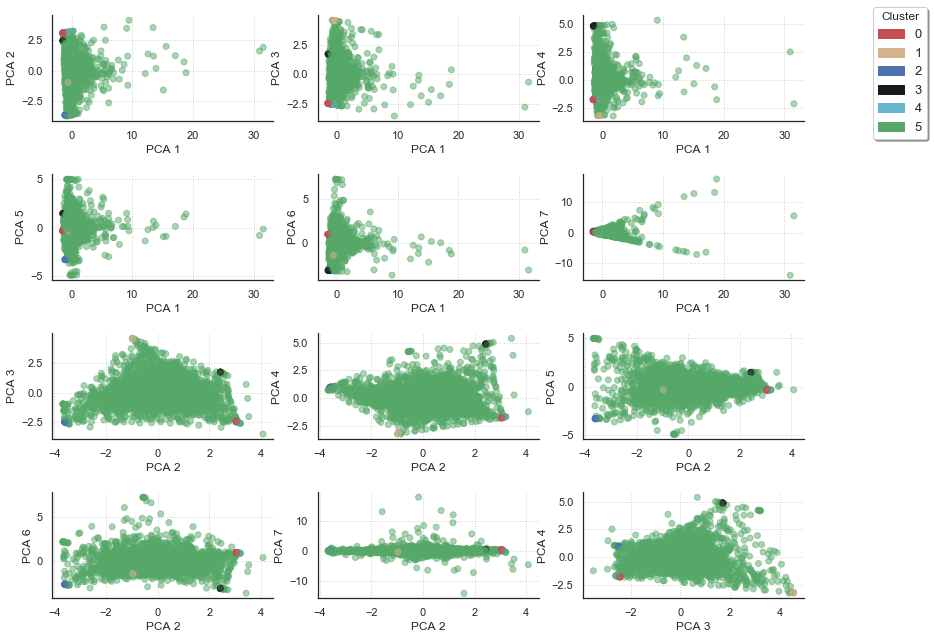

In [113]:
#pca
pca_vis(scaled_train, db_labels, 6)

In [114]:
#clustering performance measures
db_sil, db_cal, db_dav = eval_measures(scaled_train, db_labels)

Average Silhouette Score:  0.24704262775528635
Calinski-Harabasz Index:  55.43964658277347
Davies-Bouldin Index:  0.4720371528526824


In [115]:
cluster_eval = cluster_eval.append({'Algorithm':'DBSCAN', 'CalinskiHarabaszIndex':db_cal,'DaviesBouldinIndex':db_dav,'SilhouetteScore':db_sil}, ignore_index=True) 

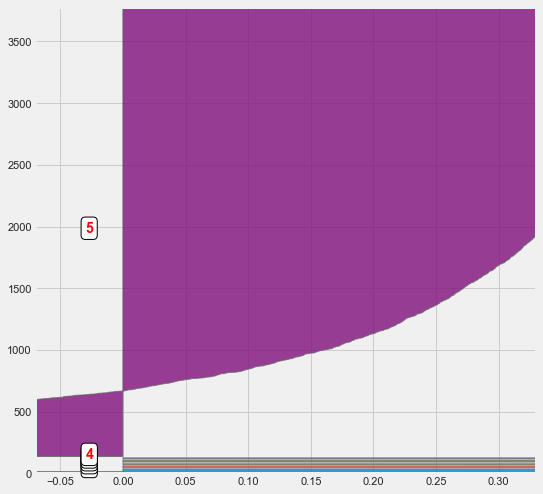

In [116]:
# create plot for individual cluster silhouette scores
sample_silhouette_values = silhouette_samples(scaled_train, db_labels)
graph_component_silhouette(6, [-0.07, 0.33], len(scaled_train), sample_silhouette_values, db_labels)

#### Mean-Shift Clustering

In [117]:
from sklearn.cluster import MeanShift

In [118]:
ms = MeanShift()
ms.fit(scaled_train)
ms_clusters = ms.cluster_centers_

In [119]:
ms_labels = ms.labels_

In [120]:
#customers per cluster
pd.DataFrame(pd.Series(ms_labels).value_counts(), columns = ['number of customers']).T

0   3   1   2   17  14  16  15  4   7   ...  10  23  \
number of customers  3564  44  32  16  11   9   6   6   3   3  ...   1   1   

                     18  20  21  9   11  13  19  22  
number of customers   1   1   1   1   1   1   1   1  

[1 rows x 24 columns]

In [121]:
#clustering performance measures
ms_sil, ms_cal, ms_dav = eval_measures(scaled_train, ms_labels)

Average Silhouette Score:  0.4129174232125971
Calinski-Harabasz Index:  81.083719161701
Davies-Bouldin Index:  0.6363126414995232


In [122]:
cluster_eval = cluster_eval.append({'Algorithm':'MeanShift', 'CalinskiHarabaszIndex':ms_cal,'DaviesBouldinIndex':ms_dav,'SilhouetteScore':ms_sil}, ignore_index=True) 

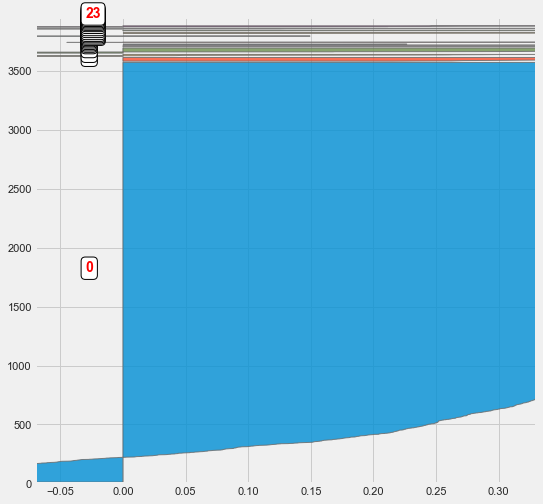

In [123]:
# create plot for individual cluster silhouette scores
sample_silhouette_values = silhouette_samples(scaled_train, ms_labels)
graph_component_silhouette(24, [-0.07, 0.33], len(scaled_train), sample_silhouette_values, ms_labels)

#### Comparing cluster results

In [124]:
cluster_eval

Algorithm  SilhouetteScore  CalinskiHarabaszIndex  \
0                      KMeans         0.204293             594.499450   
1             GaussianMixture         0.024469             105.335975   
2  Agglomerative Hierarchical         0.130199             453.895635   
3                      DBSCAN         0.247043              55.439647   
4                   MeanShift         0.412917              81.083719   

   DaviesBouldinIndex  
0            1.169072  
1            6.808886  
2            1.276819  
3            0.472037  
4            0.636313

For evaluation metrics:
+ Silhouette: the score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters. The score is higher when clusters are dense and well separated.
+ Davies Bouldin: zero is the lowest possible score. Values closer to zero indicate a better partition
+ Calinski-Harabasz: the score is higher when clusters are dense and well separated

Based on these guidelines, and by looking at the various plots and number of customers per client, KMeans appears to perform best. Although DBSCAN and Mean-Shift have better Silhouette and Davies-Bouldin scores, this has likely been achieved as in some clusters there is only one cluster (Mean-Shift) or the majority of customers are in a single cluster, with the other clusters containing only a small number of customers (DBSCAN).

Therefore, KMeans will be used as the clustering algorithm to generate classes of customers.

#### Generating the clusters with K Means

In [130]:
#create clusters with n_clusters=10
km = KMeans(init='k-means++', n_clusters = 10, n_init=100)
km_clusters = km.fit_predict(scaled_train)

#### Adding the cluster label to the dataframe

In [131]:
train.loc[:, 'cluster'] = km_clusters
train = train.drop(columns=['First Purchase'], axis=1)

In [134]:
#characterising customers in clusters
merged_df = pd.DataFrame()
for i in range(10):
    temp = pd.DataFrame(train[train['cluster'] == i].mean())
    temp = temp.T.set_index('cluster', drop = True)
    temp['size'] = train[train['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, temp])

merged_df.drop('CustomerID', axis = 1, inplace = True)

merged_df = merged_df.sort_values('sum')
merged_df = merged_df.reset_index(drop=False)

In [135]:
merged_df

cluster      count          min           max         mean            sum  \
0      7.0   2.753623   192.666957    321.089155   251.669115     724.998647   
1      0.0   2.901515   181.718977    344.825114   249.326393     834.915492   
2      2.0   3.668852   185.228066    354.421639   258.035145    1018.507311   
3      3.0   3.538168   190.943053    413.339962   281.273281    1306.712786   
4      1.0   4.102845   184.464748    429.251532   293.488555    1351.108053   
5      6.0   4.284360   200.021848    405.441943   285.849775    1462.476398   
6      9.0   5.886014   192.601818    584.718392   354.802857    2165.394171   
7      4.0   4.596154   969.136282   2043.016154  1366.910632    6561.214423   
8      8.0   1.375000  4866.106250   7326.686250  6096.396250    8830.003750   
9      5.0  35.727273    65.703636  16741.357273  3147.007330  114389.012727   

       cat_0      cat_1      cat_2      cat_3      cat_4      cat_5  size  
0  65.601939  10.299304   2.749186   7.295932   7.947868   6.109367   414  
1  22.028504  11.267017   3.485272   6.047925  50.467029   6.704252   264  
2  17.285198  10.648320   3.738737  51.551798   4.872343  11.903933   305  
3  17.076949  12.287067   3.408725  10.572092   6.399613  50.287132   262  
4  20.772858  48.387626   5.059406   8.399616   7.681346   9.699149   457  
5  21.782511  13.866094  33.446829  10.307393  11.083378   9.519180   211  
6  31.401001  19.276043   5.508408  14.408448  12.803412  16.607210  1623  
7  29.849730  21.686080   7.690133  12.878376  11.549187  16.346924   156  
8  24.929977  17.195726  12.431528  18.462865  13.629797  13.350107     8  
9  24.060536  25.406588  10.485443  16.424789   7.429704  16.192940    11

Clusters will now be analysed graphically by utilising Radar Charts, which should provide a 2D representation of each cluster. If clusters are of a good quality, all charts should look unique.

In [136]:
#functions to plot radar charts
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

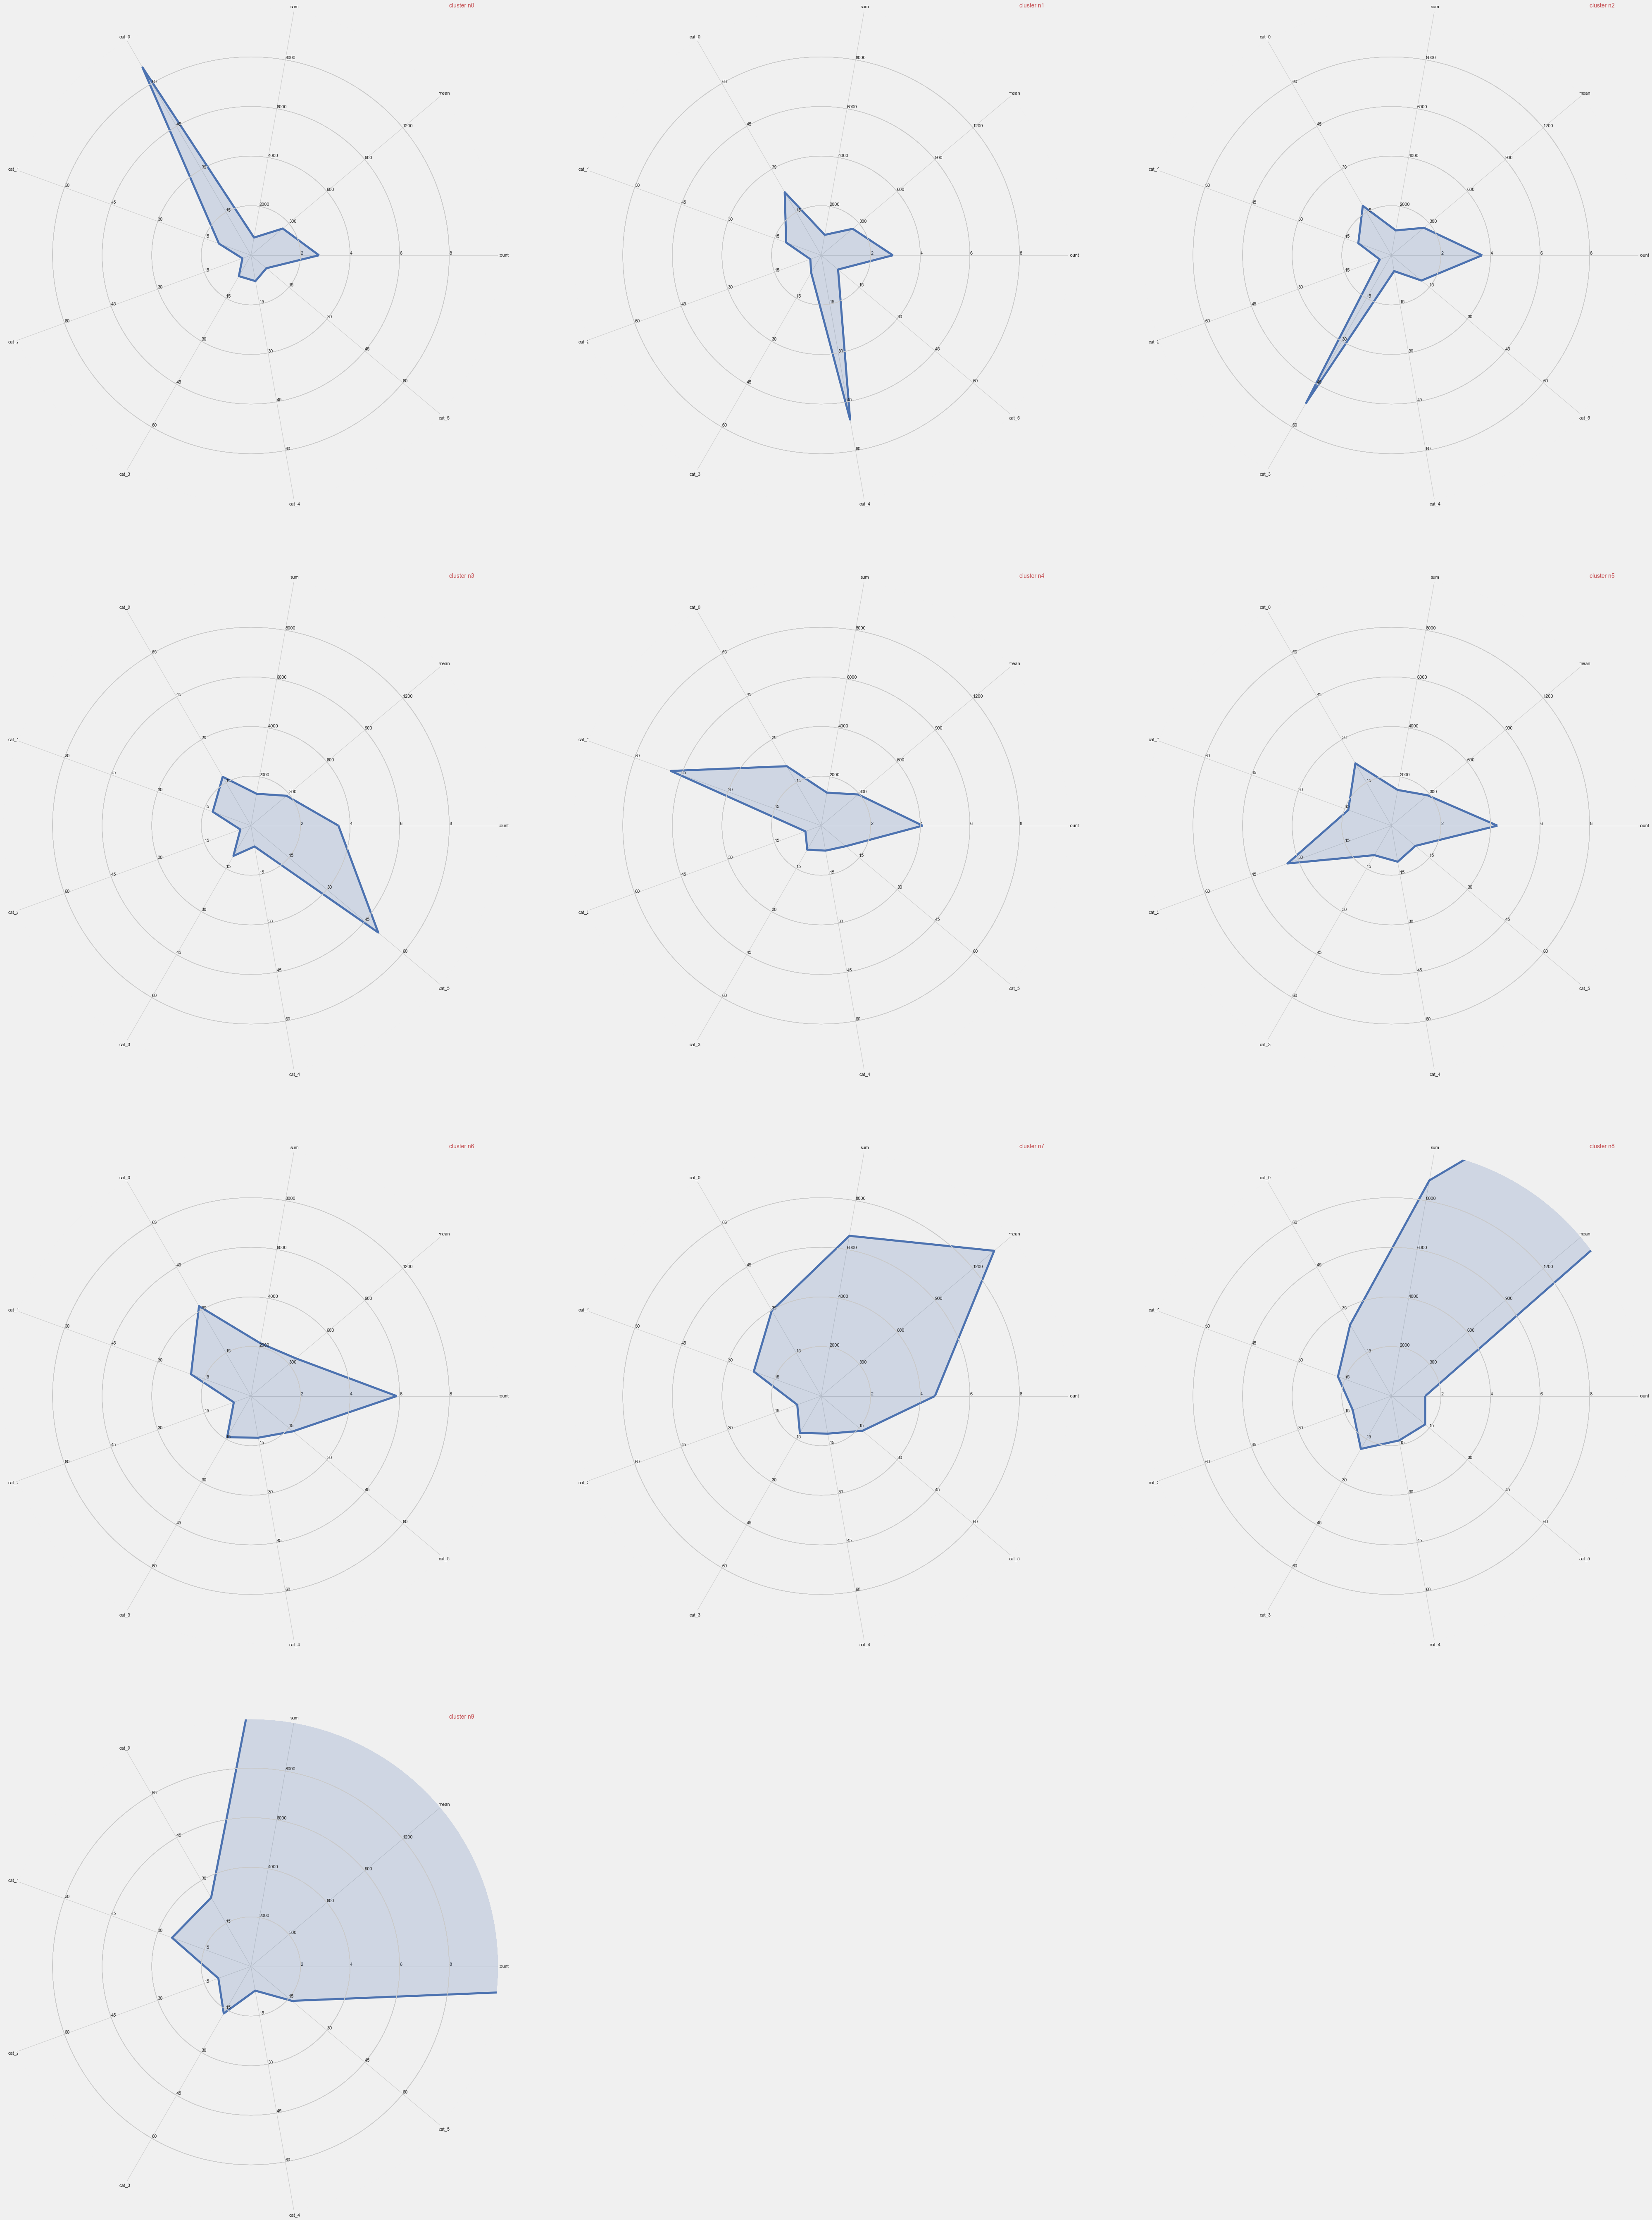

In [137]:
#plot radar charts for each cluster customers
fig = plt.figure(figsize=(50,50))

attributes = ['count', 'mean', 'sum', 'cat_0', 'cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
n_clusters = 10
n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 

    data = np.array(merged_df.loc[index[ind], attributes])  
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=5.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster n{}'.format(index[ind]), color = 'r')
    ind += 1

These clusters show very distinct distributions over the dimensions. Although overlap exists, in general overlap is not complete - there is no cluster that falls entirely within another.

It shows, for example, that clusters 0-4 are strongly dominated by purchases within particular product categories. Cluster 8 appears to be customers whose purchases are more dispersed over the categories, with high mean and sum, cluster 6 has a high count, and cluster 9 having a high mean, sum and count.

## Customer Classification

Utilising cluster labels as the Y (dependent) variable, a number of classification algorithms will be evaluated using K Fold Cross Validation on the train data to find the classifier that performs the best with the training data. 

There is conflicting opinions on which evaulation metric is most suited to a problem such as this - imbalanced multiclass classification. However, a number of sources seem to agree that micro-averaged metrics are most appropriate as it will aggregate the contributions of all classes to compute the average metric, whereas a macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally). Additional metrics will also be generated to provide further information, including accuracy, classification report and confusion matrix.

For each classifier, first optimal parameters will be found using GridSearchCV.

In [138]:
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier

In [139]:
class_df = train.copy(deep=True)

In [140]:
#separate X and Y
X = class_df[['min','max','mean','cat_0','cat_1','cat_2','cat_3','cat_4','cat_5']]
Y = class_df['cluster']

#### Helper functions

1. kfold_classification function takes the classifier, X and Y and conducts 5-fold cross validation to trian the classifier and generate predictions, which are then passed to...
2. evaluate_classifier_performance, which utilises sklearn evaluation metrics to evaluate the performance of the classifier in generating predictions
3. plot_confusion_matrix is a function that will plot the confusion matrix from the data
4. plot_learning_curve, which utilises sklearn to test the quality of the fit by drawing a learning curve, allowing for the detection of over- or under-fitting

In [141]:
def kfold_classification(classifier, X, Y):
    
    skf = StratifiedKFold(n_splits = 5, shuffle = True)
    predictions = []
    Y_actual = []
    predicted_prob = []
    
    for train_subset_index, cv_index in skf.split(X, Y):
        X_features_subset = X.iloc[train_subset_index]
        Y_subset = Y.iloc[train_subset_index]
        X_features_cv = X.iloc[cv_index]
        Y_cv = Y.iloc[cv_index]
                
        model = classifier
        model.fit(X_features_subset, Y_subset)
        pred = model.predict(X_features_cv)
        pred_prob = model.predict_proba(X_features_cv)
        
        predictions.append(pred)
        Y_actual.append(Y_cv)
        predicted_prob.append(pred_prob)
    
    predictions = [item for sublist in predictions for item in sublist]
    predicted_proba = np.array(predicted_prob)
    
    act0, act1, act2, act3, act4 = Y_actual[0], Y_actual[1], Y_actual[2], Y_actual[3], Y_actual[4]
    actual = act0.append(act1)
    actual = actual.append(act2)
    actual = actual.append(act3)
    actual = actual.append(act4)
    
    prob0, prob1, prob2, prob3, prob4 = predicted_prob[0], predicted_prob[1], predicted_prob[2], predicted_prob[3], predicted_prob[4]

    pred_proba = np.concatenate((prob0, prob1))
    pred_proba = np.concatenate((pred_proba, prob2))
    pred_proba = np.concatenate((pred_proba, prob3))
    pred_proba = np.concatenate((pred_proba, prob4))
        
    evaluate_classifier_performance(actual, predictions, pred_proba)

In [178]:
def evaluate_classifier_performance(actual, predictions):
    ### Accuracy score
    acc = accuracy_score(actual, predictions)
    print("\nAccuracy Score: ", acc)
       
    ### Micro Precision, Recall  
    precision_micro = precision_score(actual, predictions, average='micro')
    print("\nMicro Averaged Precision: ", precision_micro)
    
    recall_micro = recall_score(actual, predictions, average='micro')
    print("\nMicro Averaged Recall: ", recall_micro)
    
    #micro-averaged f1 score 
    f1_micro = f1_score(actual, predictions, average='micro')
    print("\nMicro Averaged F1 Score: ", f1_micro)
    
    ### Macro Precision, Recall  
    precision_macro = precision_score(actual, predictions, average='macro')
    print("\nMacro Averaged Precision: ", precision_macro)
    
    recall_macro = recall_score(actual, predictions, average='macro')
    print("\nMacro Averaged Recall: ", recall_macro)
    
    #micro-averaged f1 score 
    f1_macro = f1_score(actual, predictions, average='macro')
    print("\nMacro Averaged F1 Score: ", f1_macro)
    
    ### Classification Report
    print("\nClassification Report: \n", classification_report(actual, predictions))

    ### Confusion Matrix
    cm = confusion_matrix(actual, predictions)
    class_names = [i for i in range(11)]
    plot_confusion_matrix(cm, class_names)

In [143]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.figure(figsize=(20,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
   
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [144]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#### Support Vector Machine

In [145]:
from sklearn.model_selection import GridSearchCV

params_svc = {
    'kernel':('linear', 'rbf'),
    'C':[0.001, 0.01, 0.1, 1, 10],
    'gamma':[0.001, 0.01, 0.1, 1]
}

grid_search_svc = GridSearchCV(svm.SVC(), params_svc, cv=5, verbose=0)
grid_search_svc.fit(X, Y)
svc_params = grid_search_svc.best_params_


Accuracy Score:  0.8326596604688763

Micro Averaged Precision:  0.8326596604688763

Micro Averaged Recall:  0.8326596604688763

Micro Averaged F1 Score:  0.8326596604688764

Macro Averaged Precision:  0.7887280948862002

Macro Averaged Recall:  0.7908169780547467

Macro Averaged F1 Score:  0.7897355601700997

Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.81      0.81       264
           1       0.81      0.81      0.81       458
           2       0.79      0.80      0.79       305
           3       0.80      0.79      0.79       261
           4       0.77      0.79      0.78       156
           5       0.75      0.75      0.75        12
           6       0.77      0.77      0.77       211
           7       0.81      0.79      0.80       414
           8       0.71      0.71      0.71         7
           9       0.88      0.88      0.88      1623

    accuracy                           0.83      3711
   macro avg 

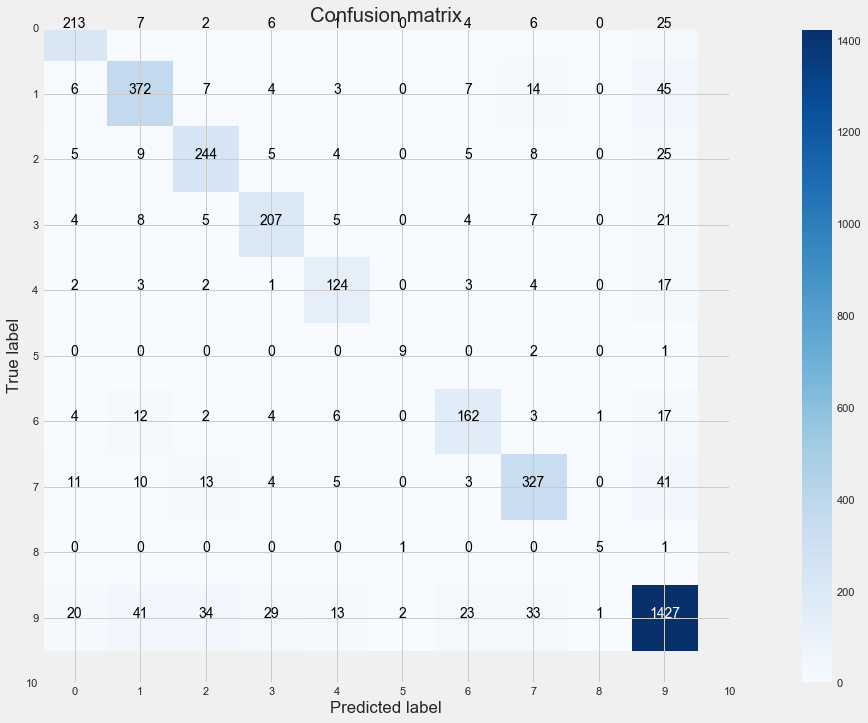

In [146]:
svc = SVC(**svc_params, probability = True)
kfold_classification(svc, X, Y)

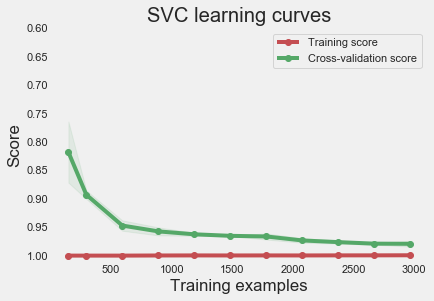

In [147]:
svc = SVC(**svc_params)
g = plot_learning_curve(svc,"SVC learning curves", X, Y, ylim = [1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### Naive Bayes


Accuracy Score:  0.7774184855834007

Micro Averaged Precision:  0.7774184855834007

Micro Averaged Recall:  0.7774184855834007

Micro Averaged F1 Score:  0.7774184855834007

Macro Averaged Precision:  0.6883895095684137

Macro Averaged Recall:  0.744931374629741

Macro Averaged F1 Score:  0.7094646638565819

Classification Report: 
               precision    recall  f1-score   support

           0       0.74      0.79      0.77       264
           1       0.79      0.68      0.73       458
           2       0.74      0.77      0.76       305
           3       0.79      0.70      0.74       261
           4       0.50      0.76      0.61       156
           5       0.47      0.67      0.55        12
           6       0.71      0.77      0.74       211
           7       0.80      0.76      0.78       414
           8       0.50      0.71      0.59         7
           9       0.83      0.82      0.83      1623

    accuracy                           0.78      3711
   macro avg  

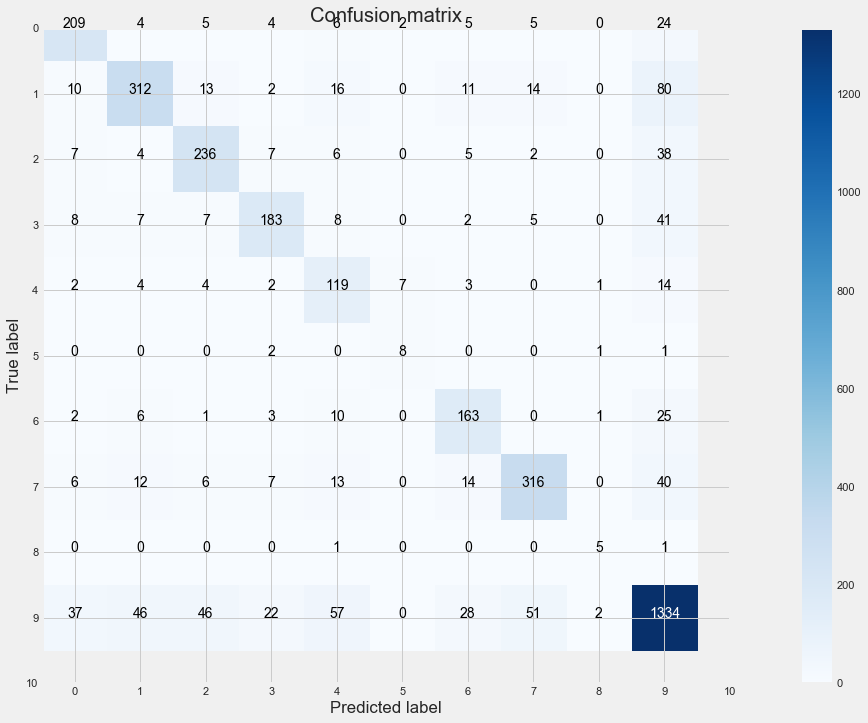

In [148]:
nb = GaussianNB()
kfold_classification(nb, X, Y)

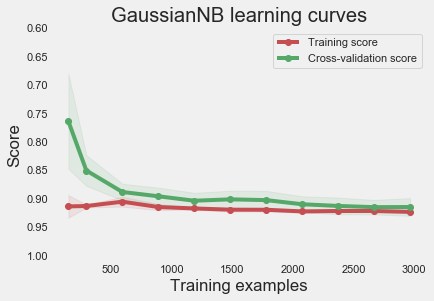

In [149]:
nb = GaussianNB()
g = plot_learning_curve(nb,"GaussianNB learning curves", X, Y, ylim = [1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### Logistic Regression

In [150]:
params_lr = {
    'penalty': ['l1','l2','elasticnet'],
    'C':[0.001, 0.01, 0.1, 1, 10]
}

grid_search_lr = GridSearchCV(LogisticRegression(), params_lr, cv=5, verbose=0)
grid_search_lr.fit(X, Y)
lr_params = grid_search_lr.best_params_


Accuracy Score:  0.7720291026677445

Micro Averaged Precision:  0.7720291026677445

Micro Averaged Recall:  0.7720291026677445

Micro Averaged F1 Score:  0.7720291026677445

Macro Averaged Precision:  0.6576896105215726

Macro Averaged Recall:  0.6667680830746142

Macro Averaged F1 Score:  0.655783736086555

Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.76      0.75       264
           1       0.78      0.78      0.78       458
           2       0.75      0.73      0.74       305
           3       0.78      0.69      0.73       261
           4       0.70      0.63      0.67       156
           5       0.33      0.50      0.40        12
           6       0.72      0.54      0.61       211
           7       0.74      0.77      0.76       414
           8       0.23      0.43      0.30         7
           9       0.81      0.84      0.82      1623

    accuracy                           0.77      3711
   macro avg  

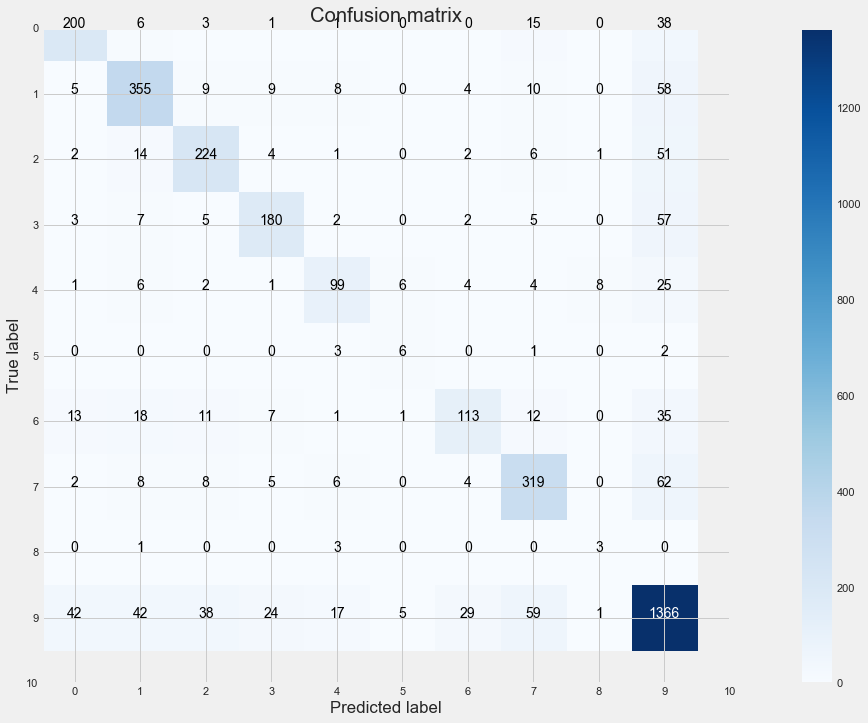

In [151]:
lr = LogisticRegression(**lr_params)
kfold_classification(lr, X, Y)

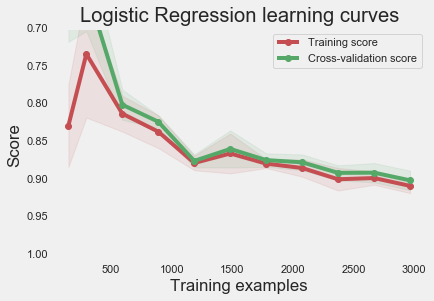

In [152]:
lr = LogisticRegression(**lr_params)
g = plot_learning_curve(lr, "Logistic Regression learning curves", X, Y, ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### Random Forest

In [153]:
params_rf = {
    'n_estimators': [4, 16, 20, 32, 64, 100, 200],
    'max_features': ['auto','sqrt','log2', None],
    'criterion': ['gini','entropy'],
    'max_depth': [None, 5, 8, 15, 25, 30],
    'min_samples_split': [2, 5, 10, 15, 100],
    'min_samples_leaf': [1, 2, 5, 10],
    'class_weight': ['balanced']
}

grid_search_rf = GridSearchCV(RandomForestClassifier(), params_rf, cv=5, verbose=0)
grid_search_rf.fit(X, Y)
rf_params = grid_search_rf.best_params_


Accuracy Score:  0.8175693883050391

Micro Averaged Precision:  0.8175693883050391

Micro Averaged Recall:  0.8175693883050391

Micro Averaged F1 Score:  0.817569388305039

Macro Averaged Precision:  0.7874505353990288

Macro Averaged Recall:  0.7887605412789427

Macro Averaged F1 Score:  0.7878307478470002

Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.78      0.78       264
           1       0.78      0.78      0.78       458
           2       0.80      0.79      0.80       305
           3       0.77      0.79      0.78       261
           4       0.73      0.79      0.76       156
           5       0.73      0.67      0.70        12
           6       0.77      0.79      0.78       211
           7       0.79      0.79      0.79       414
           8       0.86      0.86      0.86         7
           9       0.87      0.86      0.86      1623

    accuracy                           0.82      3711
   macro avg  

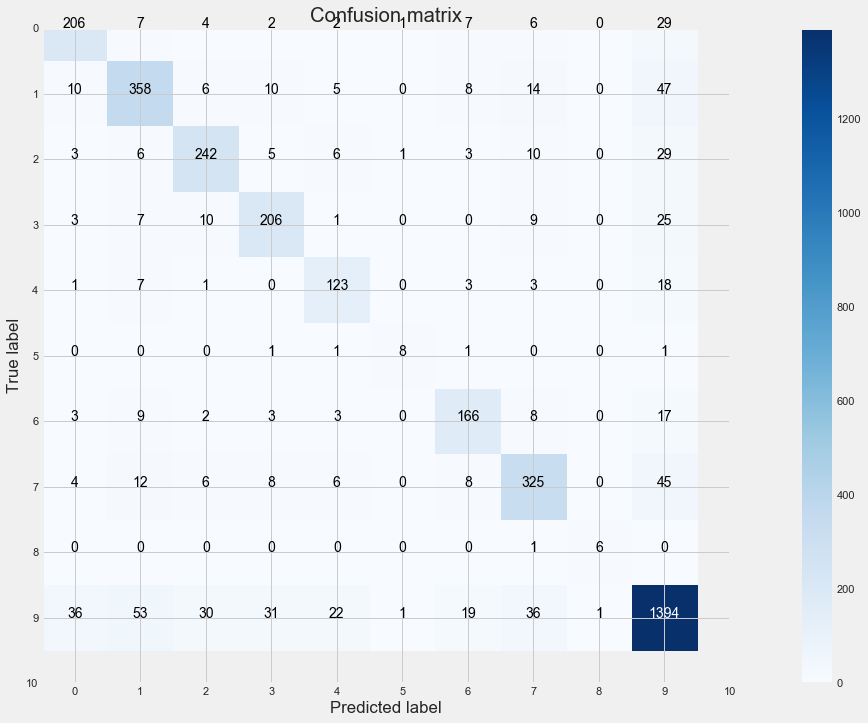

In [154]:
rf = RandomForestClassifier(**rf_params)
kfold_classification(rf, X, Y)

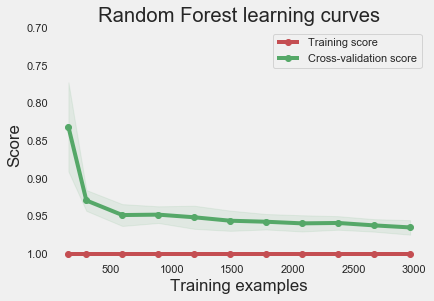

In [155]:
rf = RandomForestClassifier(**rf_params)
g = plot_learning_curve(rf, "Random Forest learning curves", X, Y, ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### K-Nearest Neighbours

In [158]:
params_knn = {
    'n_neighbors': list(range(1,30)),
    'p': [1, 2, 3, 4, 5], 
}

grid_search_knn = GridSearchCV(KNeighborsClassifier(), params_knn, cv=5, verbose=0)
grid_search_knn.fit(X, Y)
knn_params = grid_search_knn.best_params_


Accuracy Score:  0.6332524925895985

Micro Averaged Precision:  0.6332524925895985

Micro Averaged Recall:  0.6332524925895985

Micro Averaged F1 Score:  0.6332524925895985

Macro Averaged Precision:  0.6478654493438041

Macro Averaged Recall:  0.5446122004330862

Macro Averaged F1 Score:  0.5758051514817535

Classification Report: 
               precision    recall  f1-score   support

           0       0.61      0.48      0.54       264
           1       0.58      0.48      0.52       458
           2       0.65      0.44      0.52       305
           3       0.68      0.40      0.51       261
           4       0.67      0.77      0.72       156
           5       0.70      0.58      0.64        12
           6       0.54      0.16      0.24       211
           7       0.70      0.59      0.64       414
           8       0.71      0.71      0.71         7
           9       0.63      0.84      0.72      1623

    accuracy                           0.63      3711
   macro avg 

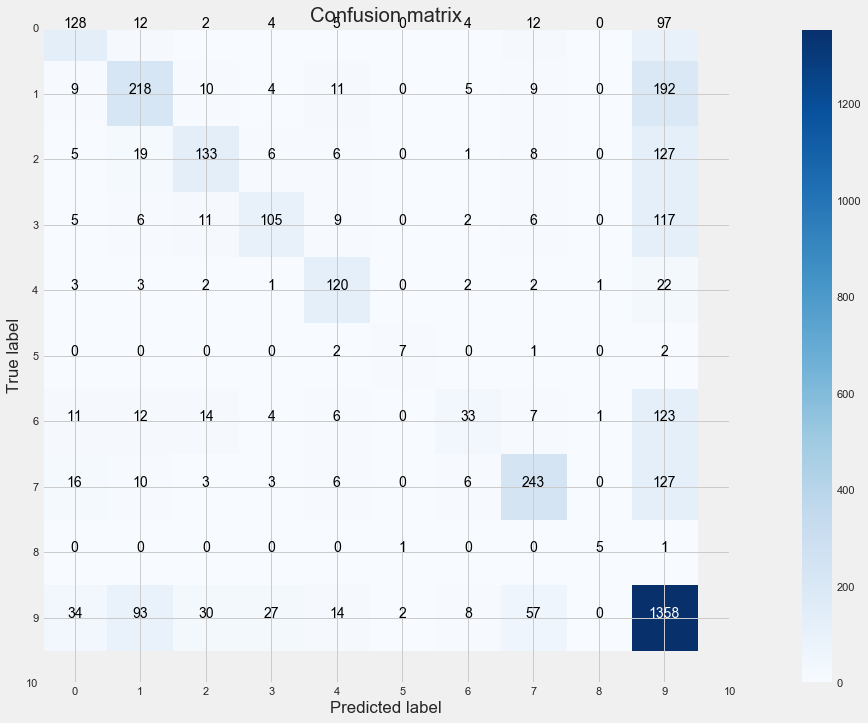

In [159]:
knn = KNeighborsClassifier(**knn_params)
kfold_classification(knn, X, Y)

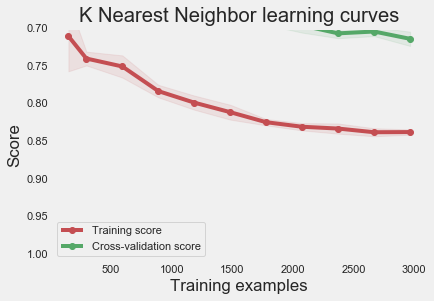

In [160]:
knn = KNeighborsClassifier(**knn_params)
g = plot_learning_curve(knn, "K Nearest Neighbor learning curves", X, Y, ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### Adaboost Classifier

In [161]:
params_ada = {
    'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200] 
}

grid_search_ada = GridSearchCV(AdaBoostClassifier(), params_ada, cv=5, verbose=0)
grid_search_ada.fit(X, Y)
ada_params = grid_search_ada.best_params_


Accuracy Score:  0.5222312045270816

Micro Averaged Precision:  0.5222312045270816

Micro Averaged Recall:  0.5222312045270816

Micro Averaged F1 Score:  0.5222312045270816

Macro Averaged Precision:  0.2672977074905121

Macro Averaged Recall:  0.32139594813944433

Macro Averaged F1 Score:  0.2864839278728665

Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       264
           1       0.72      0.79      0.75       458
           2       0.00      0.00      0.00       305
           3       0.00      0.00      0.00       261
           4       0.00      0.00      0.00       156
           5       0.75      0.75      0.75        12
           6       0.00      0.00      0.00       211
           7       0.00      0.00      0.00       414
           8       0.71      0.71      0.71         7
           9       0.49      0.96      0.65      1623

    accuracy                           0.52      3711
   macro avg

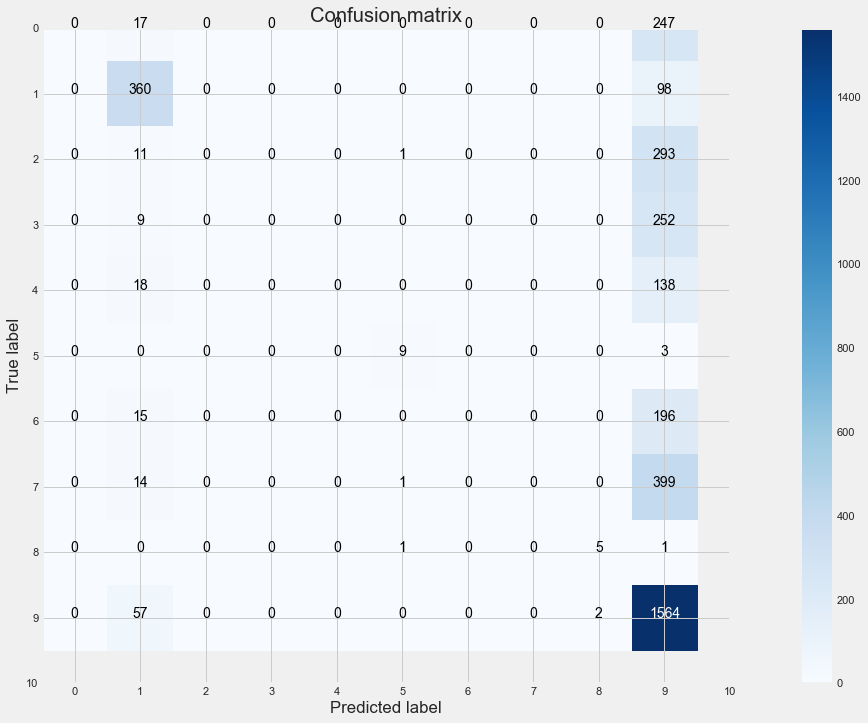

In [162]:
ada = AdaBoostClassifier(**ada_params)
kfold_classification(ada, X, Y)

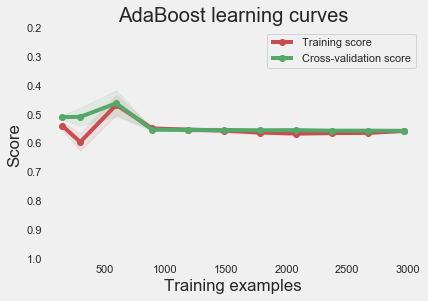

In [164]:
ada = AdaBoostClassifier(**ada_params)
g = plot_learning_curve(ada, "AdaBoost learning curves", X, Y, ylim = [1.01, 0.2], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### Gradient Boosting Classifier

In [166]:
params_gb = {
    'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01],
    'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
    'max_depth': np.linspace(1, 32, 10),
    'min_samples_split': np.linspace(1, 32, 10),
    'max_features': list(range(1,X.shape[1]))
}

grid_search_gb = GridSearchCV(GradientBoostingClassifier(), params_gb, cv=5, verbose=0)
grid_search_gb.fit(X, Y)
gb_params = grid_search_gb.best_params_


Accuracy Score:  0.6321746160064673

Micro Averaged Precision:  0.6321746160064673

Micro Averaged Recall:  0.6321746160064673

Micro Averaged F1 Score:  0.6321746160064673

Macro Averaged Precision:  0.6710714008002338

Macro Averaged Recall:  0.5918975891653923

Macro Averaged F1 Score:  0.600780744432986

Classification Report: 
               precision    recall  f1-score   support

           0       0.74      0.60      0.66       264
           1       0.77      0.61      0.68       458
           2       0.73      0.59      0.65       305
           3       0.75      0.61      0.68       261
           4       0.73      0.58      0.65       156
           5       0.01      0.50      0.02        12
           6       0.72      0.59      0.65       211
           7       0.73      0.59      0.66       414
           8       0.67      0.57      0.62         7
           9       0.85      0.68      0.75      1623

    accuracy                           0.63      3711
   macro avg  

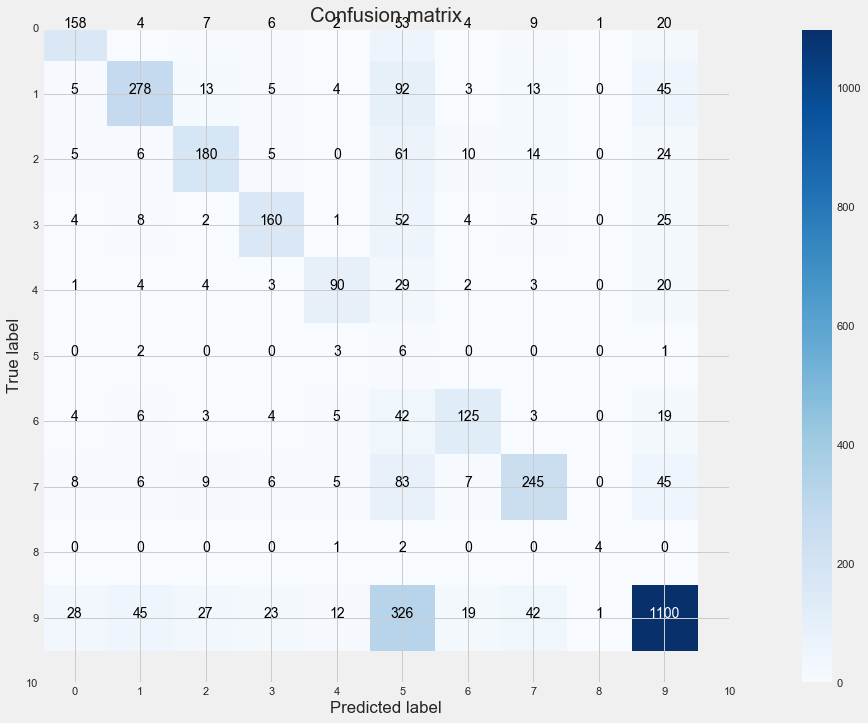

In [167]:
gb = GradientBoostingClassifier(**gb_params)
kfold_classification(gb, X, Y)

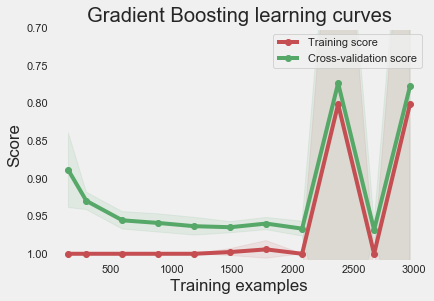

In [168]:
gb = GradientBoostingClassifier(**gb_params)
g = plot_learning_curve(gb, "Gradient Boosting learning curves", X, Y, ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### XGBoost

In [169]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

params_xgb = {
    'max_depth': range(3,10,2),
    'min_child_weight': range(1,6,2),
    'gamma': [i/10.0 for i in range(0,5)],
    'subsample': [i/10.0 for i in range(6,10)],
    'colsample_bytree': [i/10.0 for i in range(6,10)],
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100] 
}

grid_search_xgb = GridSearchCV(XGBClassifier(seed=42), params_xgb, cv=5, verbose=0)
grid_search_xgb.fit(X, Y)
xgb_params = grid_search_xgb.best_params_


Accuracy Score:  0.8291565615736998

Micro Averaged Precision:  0.8291565615736998

Micro Averaged Recall:  0.8291565615736998

Micro Averaged F1 Score:  0.8291565615736999

Macro Averaged Precision:  0.7715448247394404

Macro Averaged Recall:  0.7874256660452148

Macro Averaged F1 Score:  0.7784654616162577

Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.79      0.79       264
           1       0.81      0.80      0.80       458
           2       0.81      0.79      0.80       305
           3       0.77      0.79      0.78       261
           4       0.76      0.77      0.77       156
           5       0.75      0.75      0.75        12
           6       0.78      0.79      0.78       211
           7       0.81      0.81      0.81       414
           8       0.56      0.71      0.63         7
           9       0.87      0.87      0.87      1623

    accuracy                           0.83      3711
   macro avg 

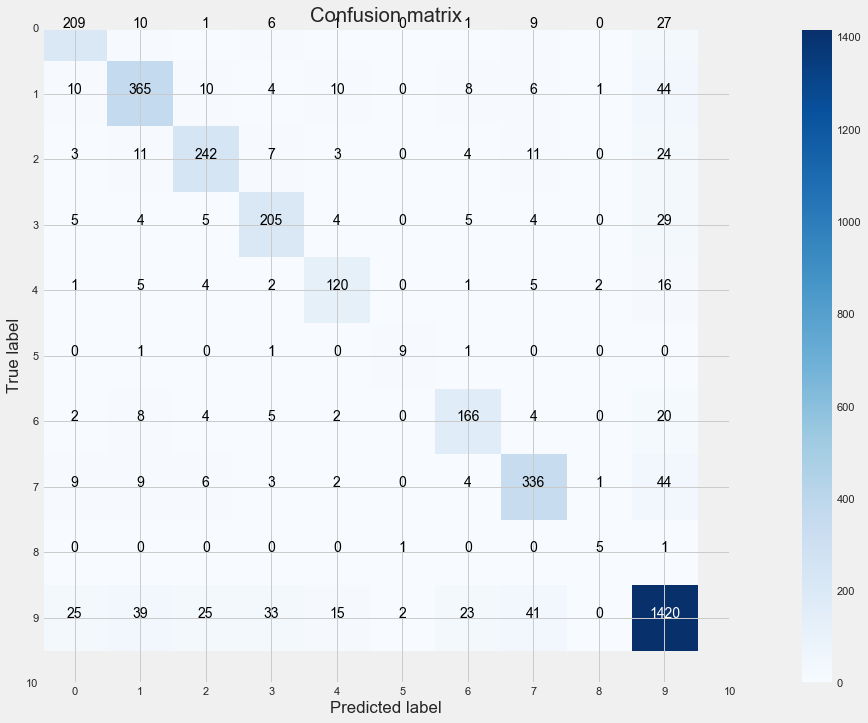

In [170]:
xgb = XGBClassifier(**xgb_params, seed=42)
kfold_classification(xgb, X, Y)

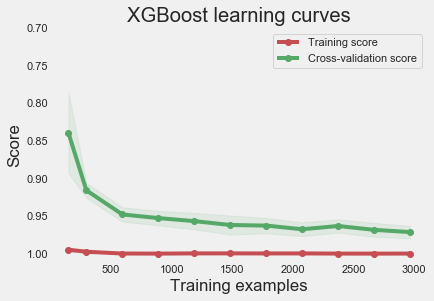

In [171]:
xgb = XGBClassifier(**xgb_params, seed=42)
g = plot_learning_curve(xgb, "XGBoost learning curves", X, Y, ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### Stacking - VotingClassifier

In [183]:
svc = SVC(**svc_params)
nb = GaussianNB()
lr = LogisticRegression(**lr_params)
rf = RandomForestClassifier(**rf_params)
knn = KNeighborsClassifier(**knn_params)
ada = AdaBoostClassifier(**ada_params)
gb = GradientBoostingClassifier(**gb_params)
xgb = XGBClassifier(**xgb_params, seed=42)

In [185]:
skf = StratifiedKFold(n_splits = 5, shuffle = True)
predictions = []
actual = []

for train_subset_index, cv_index in skf.split(X, Y):
    X_features_subset = X.iloc[train_subset_index]
    Y_subset = Y.iloc[train_subset_index]
    X_features_cv = X.iloc[cv_index]
    Y_cv = Y.iloc[cv_index]
    
    clf = VotingClassifier(estimators=[('svc', svc),
                                       ('nb', nb),
                                       ('lr', lr),
                                       ('rf', rf),
                                       ('knn',knn),
                                       ('ada',ada),
                                       ('gb', gb),
                                       ('xgb', xgb)],
                           voting='hard')
    clf.fit(X_features_subset, Y_subset)
    pred = clf.predict(X_features_cv)
    
    predictions.append(pred)
    actual.append(Y_cv)    
    
predictions = [item for sublist in predictions for item in sublist]
    
act0, act1, act2, act3, act4 = actual[0], actual[1], actual[2], actual[3], actual[4]
actual = act0.append(act1)
actual = actual.append(act2)
actual = actual.append(act3)
actual = actual.append(act4)    


Accuracy Score:  0.9797898140662894

Micro Averaged Precision:  0.9797898140662894

Micro Averaged Recall:  0.9797898140662894

Micro Averaged F1 Score:  0.9797898140662894

Macro Averaged Precision:  0.9734166130744102

Macro Averaged Recall:  0.9659174331023077

Macro Averaged F1 Score:  0.9689473870983771

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       264
           1       0.97      0.97      0.97       457
           2       0.99      0.97      0.98       305
           3       0.98      0.95      0.97       262
           4       0.94      0.99      0.96       156
           5       0.92      1.00      0.96        11
           6       0.98      0.95      0.96       211
           7       0.99      0.98      0.98       414
           8       1.00      0.88      0.93         8
           9       0.98      0.99      0.99      1623

    accuracy                           0.98      3711
   macro avg 

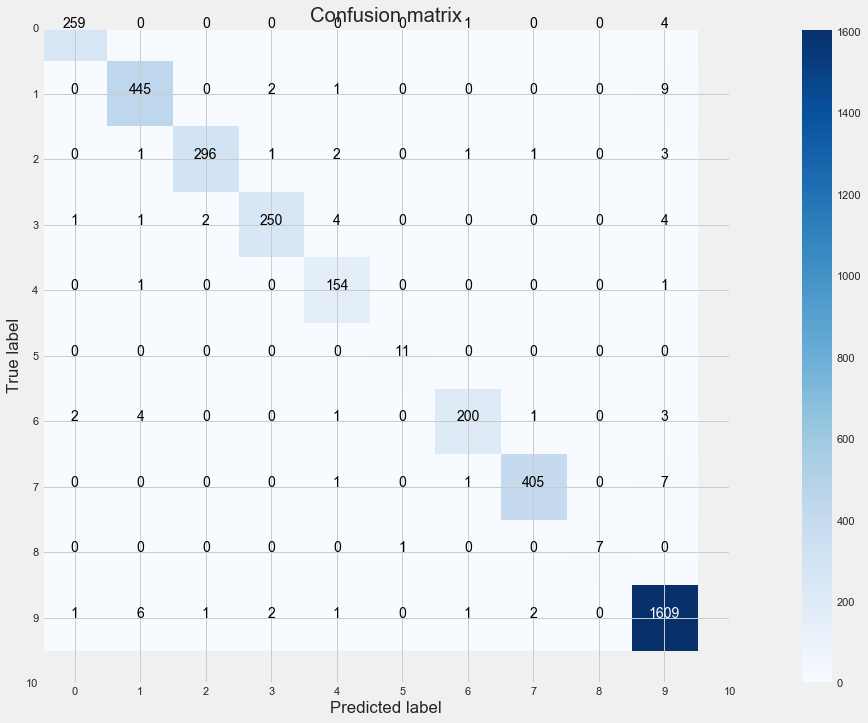

In [186]:
evaluate_classifier_performance(actual, predictions)

#### Stacking - using mlxtend simple stacking

In [195]:
from mlxtend.classifier import StackingClassifier

lr = LogisticRegression()

skf = StratifiedKFold(n_splits = 5, shuffle = True)
predictions = []
actual = []

for train_subset_index, cv_index in skf.split(X, Y):
    X_features_subset = X.iloc[train_subset_index]
    Y_subset = Y.iloc[train_subset_index]
    X_features_cv = X.iloc[cv_index]
    Y_cv = Y.iloc[cv_index]
    
    clf = StackingClassifier(classifiers=[svc, nb, rf, knn, ada, gb, xgb],
                             meta_classifier=lr)
    clf.fit(X_features_subset, Y_subset)
    pred = clf.predict(X_features_cv)
    
    predictions.append(pred)
    actual.append(Y_cv)    
    
predictions = [item for sublist in predictions for item in sublist]
    
act0, act1, act2, act3, act4 = actual[0], actual[1], actual[2], actual[3], actual[4]
actual = act0.append(act1)
actual = actual.append(act2)
actual = actual.append(act3)
actual = actual.append(act4)    


Accuracy Score:  0.9108057127458906

Micro Averaged Precision:  0.9108057127458906

Micro Averaged Recall:  0.9108057127458906

Micro Averaged F1 Score:  0.9108057127458906

Macro Averaged Precision:  0.7146608822232439

Macro Averaged Recall:  0.6875700799971854

Macro Averaged F1 Score:  0.6926141089910504

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97       264
           1       0.97      0.92      0.94       457
           2       0.93      0.94      0.93       305
           3       0.91      0.95      0.93       262
           4       0.88      0.83      0.86       156
           5       0.00      0.00      0.00        11
           6       0.78      0.38      0.51       211
           7       0.71      0.93      0.81       414
           8       0.00      0.00      0.00         8
           9       0.97      0.97      0.97      1623

    accuracy                           0.91      3711
   macro avg 

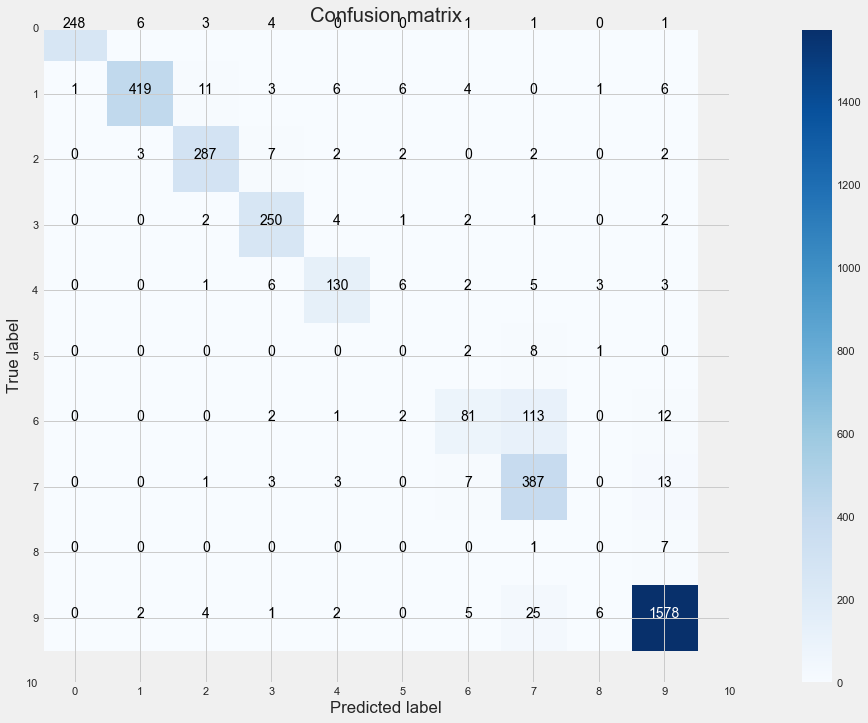

In [196]:
evaluate_classifier_performance(actual, predictions)

#### Stacking - using mlxtend and using probabilities as meta features

In [205]:
svc = SVC(**svc_params, probability=True)
nb = GaussianNB()
rf = RandomForestClassifier(**rf_params)
knn = KNeighborsClassifier(**knn_params)
ada = AdaBoostClassifier(**ada_params)
gb = GradientBoostingClassifier(**gb_params)
xgb = XGBClassifier(**xgb_params, seed=42)

In [206]:
lr = LogisticRegression()

skf = StratifiedKFold(n_splits = 5, shuffle = True)
predictions = []
actual = []

for train_subset_index, cv_index in skf.split(X, Y):
    X_features_subset = X.iloc[train_subset_index]
    Y_subset = Y.iloc[train_subset_index]
    X_features_cv = X.iloc[cv_index]
    Y_cv = Y.iloc[cv_index]
    
    clf = StackingClassifier(classifiers=[svc, nb, rf, knn, ada, gb, xgb],
                             use_probas=True,
                             average_probas=False,
                             meta_classifier=lr)
    clf.fit(X_features_subset, Y_subset)
    pred = clf.predict(X_features_cv)
    
    predictions.append(pred)
    actual.append(Y_cv)    
    
predictions = [item for sublist in predictions for item in sublist]
    
act0, act1, act2, act3, act4 = actual[0], actual[1], actual[2], actual[3], actual[4]
actual = act0.append(act1)
actual = actual.append(act2)
actual = actual.append(act3)
actual = actual.append(act4)    


Accuracy Score:  0.9784424683373754

Micro Averaged Precision:  0.9784424683373754

Micro Averaged Recall:  0.9784424683373754

Micro Averaged F1 Score:  0.9784424683373754

Macro Averaged Precision:  0.9722920479132398

Macro Averaged Recall:  0.96694820712391

Macro Averaged F1 Score:  0.9689930202246819

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       264
           1       0.98      0.97      0.98       457
           2       0.98      0.97      0.98       305
           3       0.98      0.97      0.98       262
           4       0.96      0.98      0.97       156
           5       0.92      1.00      0.96        11
           6       0.97      0.97      0.97       211
           7       0.98      0.97      0.97       414
           8       1.00      0.88      0.93         8
           9       0.98      0.99      0.98      1623

    accuracy                           0.98      3711
   macro avg   

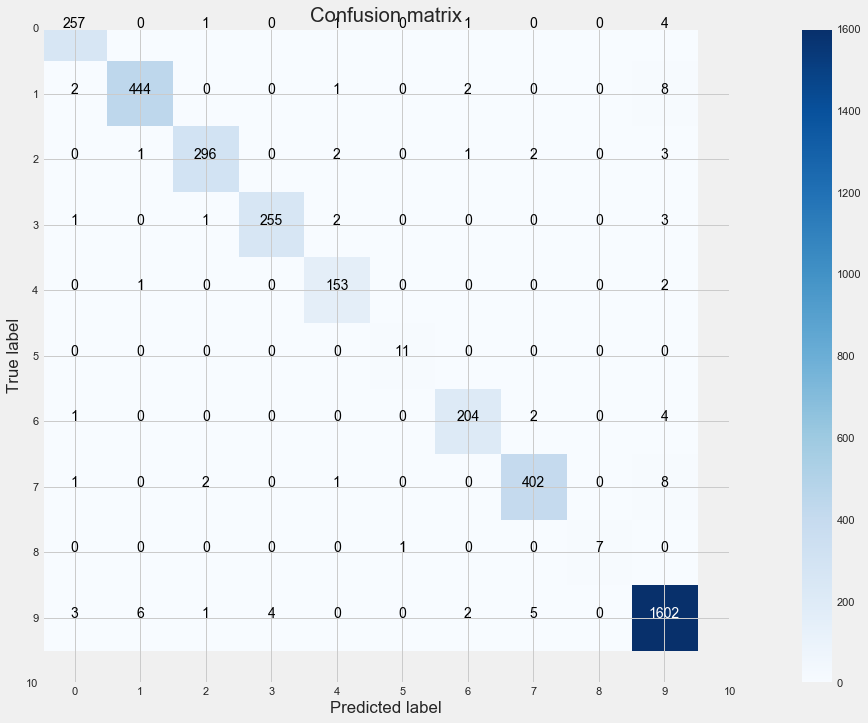

In [207]:
evaluate_classifier_performance(actual, predictions)

## Building the final model and testing on the test set

From the above micro-averaged score (as mentioned above, this is the metric of choice for imbalanced classification), the best performing model is the VotingClassifier. 

In order to give a frame of reference, the cluster labels of the test set entries will be predicted with the k-means model. 

Then the final model will be built using all of the training set (X and Y).

Once the model has been created, it will be used to predict the labels of the test set.

Using this method, there is obviously two main areas that error can enter - firstly, in predicting the cluster labels with k means, and secondly with prediting the class of the customer. If k means predictions are incorrect, this will clearly mean that even if the classifier correctly predicts what the label should be, it will be categorised as incorrect.

The value of using a model like this is, once again, to convert an unsupervised into a supervised task and enable easier evaluation of resulting labels.

In [212]:
#creating scaled test matrix
test = test.drop(columns=['sum','count','CustomerID','First Purchase'], axis=1)
test_matrix = test.as_matrix()

#scale data
scaled_test = scaler.transform(test_matrix)

#predict clusters with k means
Y_test = km.predict(scaled_test)


In [217]:
#training the final model

#individual models
svc = SVC(**svc_params)
nb = GaussianNB()
lr = LogisticRegression(**lr_params)
rf = RandomForestClassifier(**rf_params)
knn = KNeighborsClassifier(**knn_params)
ada = AdaBoostClassifier(**ada_params)
gb = GradientBoostingClassifier(**gb_params)
xgb = XGBClassifier(**xgb_params, seed=42)

final_model = VotingClassifier(estimators=[('svc', svc),
                                   ('nb', nb),
                                   ('lr', lr),
                                   ('rf', rf),
                                   ('knn',knn),
                                   ('ada',ada),
                                   ('gb', gb),
                                   ('xgb', xgb)],
                       voting='hard')
final_model.fit(X, Y)
pred = final_model.predict(test)


Accuracy Score:  0.9608482871125612

Micro Averaged Precision:  0.9608482871125612

Micro Averaged Recall:  0.9608482871125612

Micro Averaged F1 Score:  0.9608482871125612

Macro Averaged Precision:  0.9606259644580099

Macro Averaged Recall:  0.9564856071415702

Macro Averaged F1 Score:  0.9581991580967996

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99        68
           1       0.95      0.95      0.95        77
           2       0.97      0.91      0.94        33
           3       0.96      0.93      0.94        55
           4       0.84      0.91      0.87        23
           6       1.00      1.00      1.00        33
           7       0.99      0.95      0.97        81
           8       1.00      1.00      1.00         3
           9       0.96      0.97      0.96       240

    accuracy                           0.96       613
   macro avg       0.96      0.96      0.96       613
weighted avg 

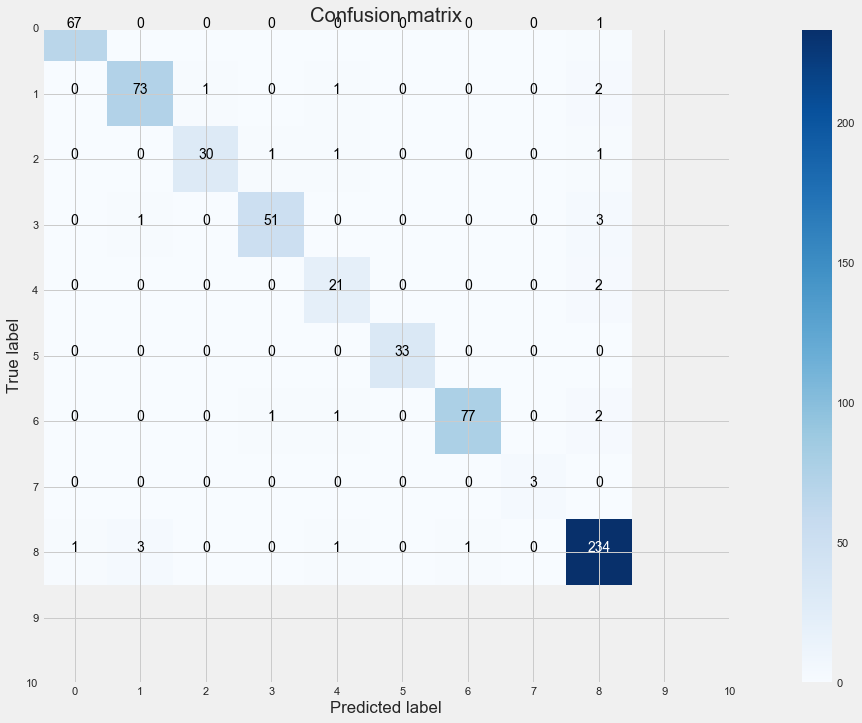

In [218]:
evaluate_classifier_performance(Y_test, pred)

The final model has performed quite well on the unseen test data from the most recent customers. It has a micro-averaged F1 score of 0.9608, which is the same as the accuracy score, suggesting that approximately 96% of customers were correctly classified by the final model. This appears to be in agreement with the confusion matrix.